# Steadystate populations

In [1]:
from qutip import basis, qeye, tensor, destroy, thermal_dm, mesolve, steadystate, Options, entropy_mutual
import qutip as qt
import numpy as np
from numpy import sqrt, pi
from utils import *
import phonons as RC
from style import *
import matplotlib.pyplot as plt
import optical as EM
import time
#from importlib import reload
import copy


G= basis(2,0)
E = basis(2,1)

sigma = G*E.dag()

I_sys = qeye(2)
initial_sys = G*G.dag()#0.5*(E+G)*(G.dag()+E.dag())
T_EM = 0.




utils imported


In [2]:
"""plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

"""
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rc('grid', linestyle="--", color='grey')
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.3
plt.rcParams['lines.linewidth'] = 2.3
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{physics} ')
colours = ['#1E90FF', '#3CB371', '#FFA500', '#FF0000']


colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
colors+=colours

In [22]:
def get_steadystates_wrt_T(alpha=0.01, Rabi=0.01, w0=0.01, N0=10, T_ph=77., Gamma=0.01, 
                           overdamped_cutoff=0, wc_tol=1e-5, Gamma_EM =7e-7, N_x=300):
    ti = time.time()
    detunings = np.linspace(-2*w0, 3*w0, N_x)
    Ts = [30,100, 300]
    inner_dict = {'nonadd' : [] , 'add': [], 'wc': []}
    data_dict ={str(T) : copy.deepcopy(inner_dict) for T in Ts}
    Rabi = Rabi*ev_to_inv_cm # 0.01*ev_to_inv_cm
    w0 = w0*ev_to_inv_cm
    Gamma = Gamma*ev_to_inv_cm
    Gamma_EM = Gamma_EM*ev_to_inv_cm
    alpha_ph = alpha*ev_to_inv_cm
    i = 0
    for T in Ts:
        if T_ph > 200:
            N = N0+4
        else:
            N=N0
        for detuning in detunings:
            epsilon = 1.6*ev_to_inv_cm
            detuning = detuning*ev_to_inv_cm #0.01*ev_to_inv_cm
            w_laser = epsilon + detuning
            
            if abs(overdamped_cutoff)>0:
                Gamma = (w0**2)/overdamped_cutoff


            H_sub = (epsilon-w_laser)*sigma.dag()*sigma + (Rabi/2)*(sigma.dag()+sigma)
            J = J_minimal
            L_RC, H, A_EM, A_ph, Z, wRC, kappa, gamma = RC.RC_mapping_general(H_sub, sigma, T, Gamma, 
                                                                                w0, alpha_ph, N,
                                                                                silent=True, w_laser=w_laser)

            L = copy.deepcopy(L_RC)
            L_add = copy.deepcopy(L_RC)
            
            I = qeye(N)
            """
            expects = [tensor(E*E.dag(), I), tensor(E*G.dag()+G*E.dag(), I), #0, 1, 2
                       Rabi*(1j*tensor(G*E.dag()-E*G.dag(), I)), # 3, TLS current
                        tensor(real_exciton, I), tensor(imag_exciton, I), #4,5
                       tensor(qeye(2), destroy(N).dag()*destroy(N)), # 6
                       tensor(qeye(2), destroy(N).dag()+destroy(N)), # 7
                       kappa*1j*tensor(E*E.dag(), destroy(N).dag()-destroy(N))] # 8
            """
            L += EM.L_nonsecular(H, A_EM, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
            ss_sc = steadystate(H, [L])
            data_dict[str(T)]['nonadd'].append((ss_sc*tensor(E*E.dag(), I)).tr())
            

            L_add += EM.L_nonsecular(tensor(H_sub, I), A_EM, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)

            ss_add = steadystate(H, [L_add])
            data_dict[str(T)]['add'].append((ss_add*tensor(E*E.dag(), I)).tr())
        i+=1
        print(i)
    scope = locals()
    PARAM_names = ['Rabi', 'kappa', 'gamma', 'Gamma_EM', 'Gamma', 'alpha_ph', 
                   'w0', 'H_sub', 'detunings', 'Ts', 'overdamped_cutoff']

    PARAMS = {name: eval(name, scope) for name in PARAM_names}
    print("Calculation complete in {} seconds".format(time.time() - ti))
    return data_dict, PARAMS

In [15]:
# red - > gold - blue
pallete = ['#4682B4', '#FFA500', '#DC143C']

def plot_population_wrt_detuning(data_dict, PARAMS, plot_name=None):
    plt.figure(figsize=(9,7))
    x_ticks_in_w0 = (ev_to_inv_cm*PARAMS['detunings']/PARAMS['w0'])
    for i, T in enumerate(PARAMS['Ts']):
        plt.plot(x_ticks_in_w0, data_dict[str(T)]['nonadd'], 
                 label='T={}K'.format(int(T)), color=pallete[i])
        plt.plot(x_ticks_in_w0, data_dict[str(T)]['add'],  
                 color=pallete[i], ls='dashed', linewidth=1.2)
    #plt.plot(x_ticks_in_w0, data_dict['77']['nonadd'], label='T=77K', color=pallete[2])
    #plt.plot(x_ticks_in_w0, data_dict[str(PARAMS['Ts'][1])]['nonadd'], label='T=100K', color=pallete[1])
    #plt.plot(x_ticks_in_w0, data_dict[str(PARAMS['Ts'][2])]['nonadd'], label='T=300K', color=pallete[0])
    
        
    #plt.plot(x_ticks_in_w0, data_dict['77']['add'], color=pallete[2], ls='dashed', linewidth=1.2)
    #plt.plot(x_ticks_in_w0, data_dict[str(PARAMS['Ts'][1])]['add'], color=pallete[1], ls='dashed', linewidth=1.2)
    #plt.plot(x_ticks_in_w0, data_dict[str(PARAMS['Ts'][2])]['add'], color=pallete[0], ls='dashed', linewidth=1.2)
    
    plt.xlabel("Detuning (Units of $\omega_0)$")
    plt.ylabel(r"$\langle\sigma^{\dagger}\sigma \rangle $")
    #plt.xlim(-1,3)
    #plt.ylim(0,1)
    plt.legend()
    if plot_name is not None:
        name = "figures/"+plot_name+'.pdf'
        plt.savefig(name)
        print("Plot saved at "+ name)
    plt.show()


In [81]:
radiative_lifetime = 4

rate_for_ns_lifetime = (1e-3*inv_ps_to_inv_cm)/ev_to_inv_cm  # this is in eV
Gamma_EM = rate_for_ns_lifetime*ev_to_inv_cm/radiative_lifetime # this is in inv_cm
print("4ns lifetime corresponds to Gamma_EM of: {}meV".format(Gamma_EM*1000))
print(rate_for_ns_lifetime)

4ns lifetime corresponds to Gamma_EM of: 1.32725meV
6.582356952451801e-07


In [9]:
35e-3*ev_to_inv_cm

282.2925

In [23]:
data_dict_1, PARAMS_1 = get_steadystates_wrt_T(alpha=20e-3, Rabi=0.5*7e-7, w0=35e-3, N0=11, 
                                               Gamma=10e-3, overdamped_cutoff=0, Gamma_EM =7e-7)

1
2
3
Calculation complete in 1849.8034608364105 seconds


In [24]:
plot_population_wrt_detuning(data_dict_1, PARAMS_1, plot_name='ss_population_detuning_T_alpha20meV_Rabi1')

Plot saved at figures/ss_population_detuning_T_alpha20meV_Rabi1.pdf


In [25]:
data_dict_2, PARAMS_2 = get_steadystates_wrt_T(alpha=20e-3, Rabi=7e-7, w0=35e-3, N0=11, 
                                               Gamma=10e-3, overdamped_cutoff=0, Gamma_EM =7e-7)

1
2
3
Calculation complete in 1804.5631501674652 seconds


In [26]:
plot_population_wrt_detuning(data_dict_2, PARAMS_2, plot_name='ss_population_detuning_T_alpha20meV_Rabi2')

Plot saved at figures/ss_population_detuning_T_alpha20meV_Rabi2.pdf


In [27]:
data_dict_3, PARAMS_3 = get_steadystates_wrt_T(alpha=20e-3, Rabi=1.5*7e-7, w0=35e-3, N0=11, 
                                               Gamma=10e-3, overdamped_cutoff=0, Gamma_EM =7e-7)

1
2
3
Calculation complete in 1806.5711379051208 seconds


In [28]:
plot_population_wrt_detuning(data_dict_3, PARAMS_3, plot_name='ss_population_detuning_T_alpha20meV_Rabi3')

Plot saved at figures/ss_population_detuning_T_alpha20meV_Rabi3.pdf


In [5]:
def ground_and_excited_manifolds(energies, states):
    # For a TLS, gives separate ground and excited state manifolds
    
    dic = {"ground": ([], []), "excited": ([], [])}
    for i, st in enumerate(states): #
        Z = tensor(E*E.dag() -G*G.dag(), qeye(evecs_[0].dims[0][1]))
        parity = Z.matrix_element(st.dag(), st)
        if parity.real<0.:
            dic['ground'][0].append(energies[i])
            dic['ground'][1].append(states[i])
        else:
            dic['excited'][0].append(energies[i])
            dic['excited'][1].append(states[i])
    return dic

In [19]:
Rabi, w0, Gamma, alpha, detuning, Gamma_EM = 0.5*7e-7, 30e-3, 10e-3, 20e-3, 0e-3, 7e-7
Rabi = Rabi*ev_to_inv_cm # 0.01*ev_to_inv_cm
w0 = w0*ev_to_inv_cm
Gamma = Gamma*ev_to_inv_cm
Gamma_EM = Gamma_EM*ev_to_inv_cm

alpha_ph = alpha*ev_to_inv_cm
epsilon = 1.*ev_to_inv_cm
detuning = detuning*ev_to_inv_cm #0.01*ev_to_inv_cm
w_laser = epsilon + detuning
H_sub = (epsilon-w_laser)*sigma.dag()*sigma + (Rabi/2)*(sigma.dag()+sigma)
L_RC, H, A_EM, A_ph, Z, wRC, kappa, gamma = RC.RC_mapping_general(H_sub, sigma, 30., Gamma, 
                                                                                w0, alpha_ph, 15,
                                                                                silent=True, w_laser=w_laser)
print(H_sub)
evals_, evecs_ = H.eigenstates()
ground_excited = ground_and_excited_manifolds(evals_, evecs_)
print(np.array(ground_excited['ground'][0])/w0)
print(np.array(ground_excited['excited'][0])/w0)
evals, evecs = H_sub.eigenstates()


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.         0.00141146]
 [0.00141146 0.        ]]
[-3.45559128e-06  9.99999838e-01  1.99999816e+00  2.99999881e+00
  3.99999995e+00  5.00000000e+00  6.00000000e+00  7.00000000e+00
  8.00000000e+00  9.00000000e+00  1.00000000e+01  1.10000000e+01
  1.20000000e+01  1.30000000e+01  1.40000000e+01]
[3.45556527e-06 1.00000016e+00 2.00000193e+00 3.00000476e+00
 4.00008483e+00 5.00124064e+00 6.01104615e+00 7.05915413e+00
 8.20106773e+00 9.48839235e+00 1.09547342e+01 1.26330728e+01
 1.45775815e+01 1.68977005e+01 1.98838848e+01]


In [12]:
Rabi, w0, Gamma, alpha, detuning = 0.5*7e-7, 30e-3, 10e-3, 10e-3, 0e-3
Rabi = Rabi*ev_to_inv_cm # 0.01*ev_to_inv_cm
w0 = w0*ev_to_inv_cm
Gamma = Gamma*ev_to_inv_cm
Gamma_EM = Gamma_EM*ev_to_inv_cm

alpha_ph = alpha*ev_to_inv_cm
epsilon = 1.*ev_to_inv_cm
detuning = detuning*ev_to_inv_cm #0.01*ev_to_inv_cm
w_laser = epsilon + detuning
H_sub = (epsilon-w_laser)*sigma.dag()*sigma + (Rabi/2)*(sigma.dag()+sigma)
L_RC, H, A_EM, A_ph, Z, wRC, kappa, gamma = RC.RC_mapping_general(H_sub, sigma, 30., Gamma, 
                                                                                w0, alpha_ph, 15,
                                                                                silent=True, w_laser=w_laser)
evals_, evecs_ = H.eigenstates()
ground_excited = ground_and_excited_manifolds(evals_, evecs_)
print(np.array(ground_excited['ground'][0])/w0)
print(np.array(ground_excited['excited'][0])/w0)
evals, evecs = H_sub.eigenstates()
print(Rabi)

[-4.48972702e-06  9.99997861e-01  1.99999960e+00  2.99999918e+00
  3.99999842e+00  4.99999910e+00  5.99999994e+00  7.00000000e+00
  8.00000000e+00  9.00000000e+00  1.00000000e+01  1.10000000e+01
  1.20000000e+01  1.30000000e+01  1.40000000e+01]
[4.48970279e-06 1.00000214e+00 2.00000040e+00 3.00000082e+00
 4.00000169e+00 5.00000499e+00 6.00009544e+00 7.00142127e+00
 8.01298120e+00 9.07062905e+00 1.02419613e+01 1.15940739e+01
 1.31871643e+01 1.51162226e+01 1.76294284e+01]
0.002822925


In [102]:
print(PARAMS_1['detunings'][np.argmax(data_dict_1['100']['nonadd'])]*ev_to_inv_cm)
print(PARAMS_1)

-119.13261467889907
{'Rabi': 0.002822925, 'kappa': 267.44855393515746, 'gamma': 0.04547284088339867, 'Gamma_EM': 0.00564585, 'Gamma': 80.655, 'alpha_ph': 161.31, 'w0': 282.2925, 'H_sub': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.0000000e+00  1.4114625e-03]
 [ 1.4114625e-03 -5.6458500e+02]], 'shift': 126.69257773764238, 'detunings': array([-0.07      , -0.0687156 , -0.06743119, -0.06614679, -0.06486239,
       -0.06357798, -0.06229358, -0.06100917, -0.05972477, -0.05844037,
       -0.05715596, -0.05587156, -0.05458716, -0.05330275, -0.05201835,
       -0.05073394, -0.04944954, -0.04816514, -0.04688073, -0.04559633,
       -0.04431193, -0.04302752, -0.04174312, -0.04045872, -0.03917431,
       -0.03788991, -0.0366055 , -0.0353211 , -0.0340367 , -0.03275229,
       -0.03146789, -0.03018349, -0.02889908, -0.02761468, -0.02633028,
       -0.02504587, -0.02376147, -0.02247706, -0.02119266, -0.01990826,
       -0.01862385, -0.01733945, -0.0

In [20]:
plot_population_wrt_detuning(data_dict_1, PARAMS_1, plot_name='ss_population_detuning_T_alpha10meV_2')

Plot saved at figures/ss_population_detuning_T_alpha10meV_2.pdf


In [ ]:
data_dict_1, PARAMS_1 = get_steadystates_wrt_T(alpha=10e-3, Rabi=7e-7, w0=35e-3, N0=6, 
                                               Gamma=10e-3, overdamped_cutoff=0, Gamma_EM =7e-7)

In [91]:
data_dict_2, PARAMS_2 = get_steadystates_wrt_T(alpha=10e-3, Rabi=1e-3, w0=20e-3, N0=4, 
      Gamma=0.2e-3, overdamped_cutoff=0, Gamma_EM =7e-7)

1
2
3
Calculation complete in 70.17808270454407 seconds


In [92]:
plot_population_wrt_detuning(data_dict_2, PARAMS_2)

# Population as a function of detuning and Rabi frequency

In [11]:
def get_steadystates_wrt_Rabi(alpha=0.01, T=77., w0=0.01, N=10, T_ph=77., Gamma=0.01, 
                           overdamped_cutoff=0, wc_tol=1e-5, Gamma_EM =7e-7):
    ti = time.time()
    detunings = np.linspace(-w0, 3*w0, 50)
    Rabis = [0.5e-3,1e-3,1.5e-3]
    inner_dict = {'nonadd' : [] , 'add': [], 'wc': []}
    data_dict ={str(int(R*1000)) : copy.deepcopy(inner_dict) for R in Rabis}
    
    w0 = w0*ev_to_inv_cm
    Gamma = Gamma*ev_to_inv_cm
    Gamma_EM = Gamma_EM*ev_to_inv_cm
    alpha_ph = alpha*ev_to_inv_cm
    i = 0
    for Rabi in Rabis:
        Rabi = Rabi*ev_to_inv_cm # 0.01*ev_to_inv_cm
        rab_label = str(int(Rabi*1000/ev_to_inv_cm))
        
        for detuning in detunings:
            epsilon = 1*ev_to_inv_cm
            detuning = detuning*ev_to_inv_cm #0.01*ev_to_inv_cm
            w_laser = epsilon + detuning
            if abs(overdamped_cutoff)>0:
                Gamma = (w0**2)/overdamped_cutoff


            H_sub = (epsilon-w_laser)*sigma.dag()*sigma + (Rabi/2)*(sigma.dag()+sigma)
            shift = 0.5*pi*alpha_ph/2
            #print (epsilon, detuning, w_laser, Rabi, w0, Gamma, alpha_ph, Gamma_EM)
            energies, states = exciton_states(detuning, Rabi, shift=shift)

            real_exciton = 0.5*(states[1]*states[0].dag() + states[0]*states[1].dag())
            imag_exciton = 0.5*1j*(states[1]*states[0].dag() - states[0]*states[1].dag())
            J = J_minimal
            L_RC, H, A_EM, A_ph, Z, wRC, kappa, gamma = RC.RC_mapping_general(H_sub, sigma, T, Gamma, 
                                                                                w0, alpha_ph, N,
                                                                                silent=True, w_laser=w_laser)

            L = copy.deepcopy(L_RC)
            L_add = copy.deepcopy(L_RC)
            
            I = qeye(N)
            
            L += EM.L_nonsecular(H, A_EM, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)
            ss_sc = steadystate(H, [L])
            d = qt.destroy(N)
            data_dict[rab_label]['nonadd'].append((ss_sc*tensor(qt.qeye(2), d.dag()*d)).tr())
            

            L_add += EM.L_nonsecular(tensor(H_sub, I), A_EM, epsilon, Gamma_EM, T_EM, J, silent=True, w_laser=w_laser)

            ss_add = steadystate(H, [L_add])
            data_dict[rab_label]['add'].append((ss_add*tensor(E*E.dag(), I)).tr())
        print(rab_label)
    scope = locals()
    PARAM_names = ['Rabis', 'kappa', 'gamma', 'Gamma_EM', 'Gamma', 'alpha_ph', 
                   'w0', 'H_sub', 'shift', 'detunings', 'T', 'overdamped_cutoff']

    PARAMS = {name: eval(name, scope) for name in PARAM_names}
    print("Calculation complete in {} seconds".format(time.time() - ti))
    return data_dict, PARAMS

In [ ]:
Rabi_dict_1, PARAMS_R1 = get_steadystates_wrt_Rabi(alpha=5e-3, w0=35e-3, N=8, T=77,
                          Gamma=10e-3, overdamped_cutoff=0, Gamma_EM =7e-7)

In [10]:
plot_population_wrt_Rabi(Rabi_dict_1, PARAMS_R1, plot_name='steadystate_N_wrt_Rabi')

Plot saved at figures/steadystate_wrt_Rabi.pdf


In [14]:
Rabi_dict_3, PARAMS_R3 = get_steadystates_wrt_Rabi(alpha=5e-3, w0=20e-3, N=8, T=77,
                          Gamma=12e-3, overdamped_cutoff=0, Gamma_EM =7e-7)

1
5
10
Calculation complete in 267.069679022 seconds


In [17]:
plot_population_wrt_Rabi(Rabi_dict_3, PARAMS_R3, plot_name='steadystate_N_wrt_Rabi', ylabel='')

Plot saved at figures/steadystate_N_wrt_Rabi.pdf


In [55]:
Rabi_dict_2, PARAMS_R2 = get_steadystates_wrt_Rabi(alpha=10e-3, w0=20e-3, N=10, T=77,
                          Gamma=12e-3, overdamped_cutoff=0, Gamma_EM =7e-7)

1
5
10
Calculation complete in 277.2026150226593 seconds


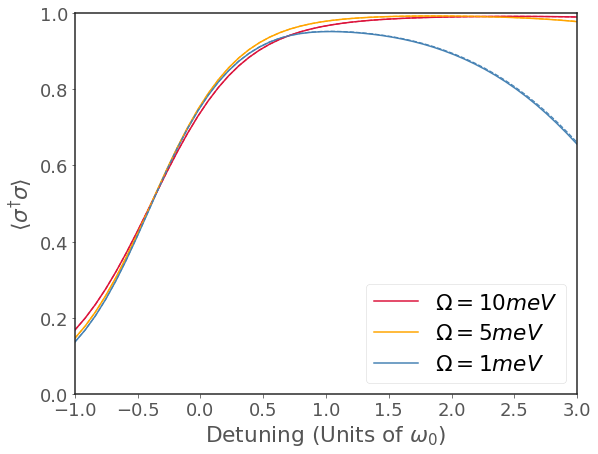

In [59]:
plot_population_wrt_Rabi(Rabi_dict_2, PARAMS_R2)

In [16]:
# Green - > turquoise - aquamarine
pallete = ['#DC143C', '#FFA500',  '#4682B4']

def plot_population_wrt_Rabi(data_dict, PARAMS, plot_name=None):
    plt.figure(figsize=(9,7))
    x_ticks_in_w0 = ev_to_inv_cm*PARAMS['detunings']/PARAMS['w0']
    plt.plot(x_ticks_in_w0, data_dict['10']['nonadd'], label='$\Omega=10meV$', color=pallete[0])
    plt.plot(x_ticks_in_w0, data_dict['5']['nonadd'], label='$\Omega=5meV$', color=pallete[1])
    plt.plot(x_ticks_in_w0, data_dict['1']['nonadd'], label='$\Omega=1meV$', color=pallete[2])
    
    #plt.plot(x_ticks_in_w0, data_dict['10']['add'], color=pallete[0], ls='dashed', linewidth=1.2)
    #plt.plot(x_ticks_in_w0, data_dict['5']['add'], color=pallete[1], ls='dashed', linewidth=1.2)
    #plt.plot(x_ticks_in_w0, data_dict['1']['add'],  color=pallete[2], ls='dashed', linewidth=1.2)
    
    plt.xlabel("Detuning (Units of $\omega_0)$")
    plt.ylabel(r"$\langle\sigma^{\dagger}\sigma \rangle $")
    plt.xlim(-1,3)
    plt.ylim(0,1)
    plt.legend()
    if plot_name is not None:
        name = "figures/"+plot_name+'.pdf'
        plt.savefig(name)
        print("Plot saved at "+ name)

# Analytical Weak coupling phonons

In [6]:
reload(EM)

def weak_phonon(H_sub, alpha=0., w0=0., Gamma=0., T=0., tol=1e-5):
    A = sigma.dag()*sigma 
    
    return EM.L_non_rwa(H_sub, A, w0, Gamma, T, J_underdamped, 
                     principal=True, silent=True, alpha=alpha, tol=tol) # need principal value parts



def weak_phonon_analytic(detuning=0., Rabi=0, alpha=0., w0=0., Gamma=0., T=0.):
    H_S = qt.Qobj([[0, Rabi/2.],[Rabi/2., -detuning]])
    evals, evecs = exciton_states(detuning, Rabi)
    eps = detuning
    eta= np.sqrt(eps**2 + Rabi**2)
    psi_m, psi_p = evecs[0], evecs[1]
    #print evals, psi_m, psi_p
    #print detuning, Rabi, alpha, w0, Gamma, T_ph
    
    E_proj = ((eta-eps)*psi_p*psi_p.dag() + (eta+eps)*psi_m*psi_m.dag())/(2*eta)
    E_proj -= Rabi*(psi_m*psi_p.dag()+psi_p*psi_m.dag())/(2*eta)
    E_op = sigma.dag()*sigma
    assert E_proj == E_op
    beta = beta_f(T)
    G0 = EM.DecayRate(0, beta, J_underdamped,  Gamma, w0, alpha=alpha, tol=1e-7)
    Gp = EM.DecayRate(eta, beta, J_underdamped,  Gamma, w0, alpha=alpha, tol=1e-7)
    Gm = EM.DecayRate(-eta, beta, J_underdamped,  Gamma, w0, alpha=alpha, tol=1e-7)
    Z = G0*((eta-eps)*psi_p*psi_p.dag() + (eta+eps)*psi_m*psi_m.dag())/(2*eta)
    Z -= Rabi*(Gp*psi_m*psi_p.dag()+Gm*psi_p*psi_m.dag())/(2*eta)
    #print Z
    
    L =  qt.spre(E_op*Z) - qt.sprepost(Z, E_op)
    L += qt.spost(Z.dag()*E_op) - qt.sprepost(E_op, Z.dag())
    
    return L


'\ndetuning = ev_to_inv_cm*6.0010*3e-3\nw0 = ev_to_inv_cm*6.0*3e-3\nRabi = 1e-3*ev_to_inv_cm\nGamma = w0*2\nalpha = 10e-3*ev_to_inv_cm\nT=77\nH_sub = -detuning*sigma.dag()*sigma + 0.5*Rabi*(sigma.dag()+sigma)\n#energies, states = H_sub.eigenstates()\n#print(H_sub, states[0]*states[0].dag())\n\nL1 = weak_phonon_analytic(detuning=detuning, Rabi=Rabi, alpha=alpha, w0=w0, Gamma=Gamma, T=T)\n#print("NOW THE NUMERICAL ONE ")\nL2 = weak_phonon(H_sub, alpha=alpha, w0=w0, Gamma=Gamma, T=T)\nprint(L1, \'\n\',L2)\nprint(L1.eigenenergies(), \'\n\',L2.eigenenergies())\ndetuning = ev_to_inv_cm*6.0010*3e-3\nw0 = ev_to_inv_cm*6.0*3e-3\nRabi = 1e-3*ev_to_inv_cm\nGamma = w0*2\nalpha = 10e-3*ev_to_inv_cm\nT=77\nimport wc_phonons as wc\nreload(wc)\nL3 = wc.L_wc_analytic(detuning=detuning, Rabi=Rabi, alpha=alpha, w0=w0, Gamma=Gamma, T=T)\nH_sub = -detuning*sigma.dag()*sigma + 0.5*Rabi*(sigma.dag()+sigma)\ndyn = mesolve(H_sub)\nprint(L3, L3.eigenenergies())'

In [23]:

def plot_wc_dynamics(data_dict, timelength=1):
    labels = ['Full', 'Redfield']
    linestyles = ['solid', 'solid']
    timelist = data_dict['timelist']
    alphas = [1, 0.5]
    f, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(12,12), sharex=True,tight_layout=True)
    for i, suff in enumerate(['_sc', '_wc']):
        dynamics = data_dict['dynamics'+suff]
        ss = data_dict['ss_expvals'+suff]
        l, c, linestyle, a = labels[i], colourWheel[i], linestyles[i], alphas[i]
        
        ax1.plot(timelist, dynamics.expect[1].real, label=l, color=c, ls=linestyle, alpha=a) # TLS pop.
        ax1.axhline(ss[1], color=c, ls='dotted')
        ax2.plot(timelist, dynamics.expect[2].real, label=l, color=c, ls=linestyle, alpha=a) # sigma_x
        ax2.axhline(ss[2].real, color=c, ls='dotted')
        #ax3.plot(timelist, dynamics.expect[4].real, label=l, color=c, ls=linestyle, alpha=a) # Real eig
        #ax3.axhline(ss[4].real, color=c, ls='dotted')
        ax3.plot(timelist, dynamics.expect[3].real, label=l, color=c, ls=linestyle, alpha=a) # TLS current
        ax3.axhline(ss[3].real, color=c, ls='dotted')
        
    ax1.set_ylabel(r'$\langle\sigma^{\dagger}\sigma\rangle$')
    ax2.set_ylabel(r'$\langle\sigma_x\rangle$')
    #ax3.set_ylabel(r'$  \langle -| \rho_S(t)|+\rangle |$')
    ax3.set_ylabel(r'$\langle I_{g \to e} \rangle$')
    #ax4.set_ylabel(r'$2\Im\langle |+\rangle\!\langle -|\rangle$')
    ax3.set_xlabel('Time ($ps$)')
    ax1.legend(loc='best')
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(timelist[0], timelist[int((len(timelist)-1)*timelength)])
        ax.set_aspect('auto')
    plt.show()

# Convergence

# Notes on parameters

Detunings are going to be $(1meV, 10meV)$.

Coupling strengths are going to be $(1meV, 10meV, 100meV)$.

Temperatures are $35, 77, 150K$

Mode frequencies are $6meV, 12meV, 18meV$ (or $48, 96, 145 cm^{-1}$)

In [12]:
def mode_info(w0=100., T=77, alpha=10.):
    print("kBT/w0={:0.3f}, n(w)={:0.3f}, w0={:0.4f}meV, N={}, N={}".format(0.695*T/w0, Occupation(w0, T), 
                                                100*w0/ev_to_inv_cm, 
                                                get_converged_N(alpha, w0,T), 
                                                  N_estimate(alpha, w0, T)))

T = 35
alpha = 800

w0=6e-3*ev_to_inv_cm
T = 77
mode_info(w0=w0, T=T, alpha=0.)
mode_info(w0=w0, T=T, alpha=10.)
mode_info(w0=w0, T=T, alpha=100.)
mode_info(w0=w0, T=T, alpha=200.)
mode_info(w0=w0, T=T, alpha=600.)

kBT/w0=1.106, n(w)=0.680, w0=0.6000meV, N=3, N=3
kBT/w0=1.106, n(w)=0.680, w0=0.6000meV, N=15, N=6
kBT/w0=1.106, n(w)=0.680, w0=0.6000meV, N=18, N=9
kBT/w0=1.106, n(w)=0.680, w0=0.6000meV, N=21, N=14
Error could only converge to 0.013183527767764446
kBT/w0=1.106, n(w)=0.680, w0=0.6000meV, N=28, N=24


# Comparison to Weak coupling theory

Detunings are going to be $(1meV, 10meV)$.

Coupling strengths are going to be $(1meV, 10meV, 100meV)$.

Temperatures are $35, 77, 150K$

Mode frequencies are $6meV, 12meV, 18meV$ (or $48, 96, 145 cm^{-1}$)

In [29]:
def get_data_and_plot_for_detunings(T=35, alpha=1e-3, w0=6e-3, Gamma=12e-3, Rabi = 1e-3, tf=4, 
                                    err_threshold=0.01, wc_tol=1e-5):
    # WC: 1meV. # Detuning dependence
    N = RC.N_estimate_eV(alpha, w0, T, err_threshold=err_threshold, min_N=4, max_N=25, silent=True)
    print("USING N={}".format(N))
    # Detuning dependence
    shift = 0.5*(pi*alpha/2)/ev_to_inv_cm
    detuning = shift
    print("Detuning : {:0.4f}meV".format(1000*detuning))
    DD = WC_comparison(detuning=detuning, alpha=alpha, Rabi=Rabi, w0=w0, N=N, T_ph=T, 
                       Gamma=Gamma, tf=tf, wc_tol=wc_tol)
    plot_wc_dynamics(DD, timelength=1)

    detuning = 6e-3
    print("Detuning : {:0.4f}meV".format(1000*detuning))
    DD = WC_comparison(detuning=detuning, alpha=alpha, Rabi=Rabi, w0=w0, N=N, T_ph=T, 
                       Gamma=Gamma, tf=tf, wc_tol=wc_tol)
    plot_wc_dynamics(DD, timelength=1)
    N+=1
    detuning = 12e-3
    print("Detuning : {:0.4f}meV".format(1000*detuning))
    DD = WC_comparison(detuning=detuning, alpha=alpha, Rabi=Rabi, w0=w0, N=N, T_ph=T, 
                       Gamma=Gamma, tf=tf*0.5, wc_tol=wc_tol)
    plot_wc_dynamics(DD, timelength=1)

    detuning = 18e-3
    print("Detuning : {:0.4f}meV".format(1000*detuning))
    DD = WC_comparison(detuning=detuning, alpha=alpha, Rabi=Rabi, w0=w0, N=N, T_ph=T, 
                       Gamma=Gamma, tf=tf*0.5, wc_tol=wc_tol)
    plot_wc_dynamics(DD, timelength=1)



USING N=6
Detuning : 0.0001meV
Dynamics complete


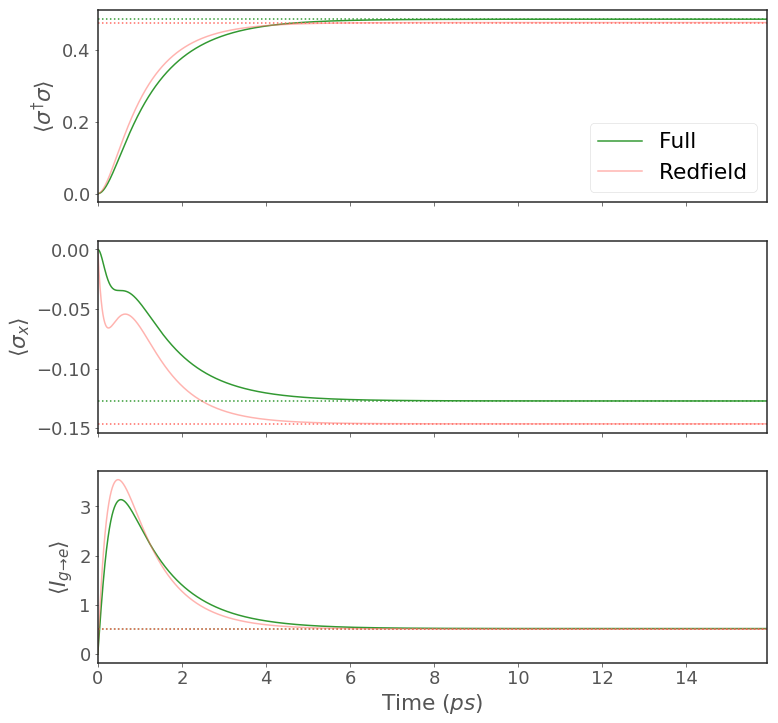

Detuning : 1.0000meV
Dynamics complete


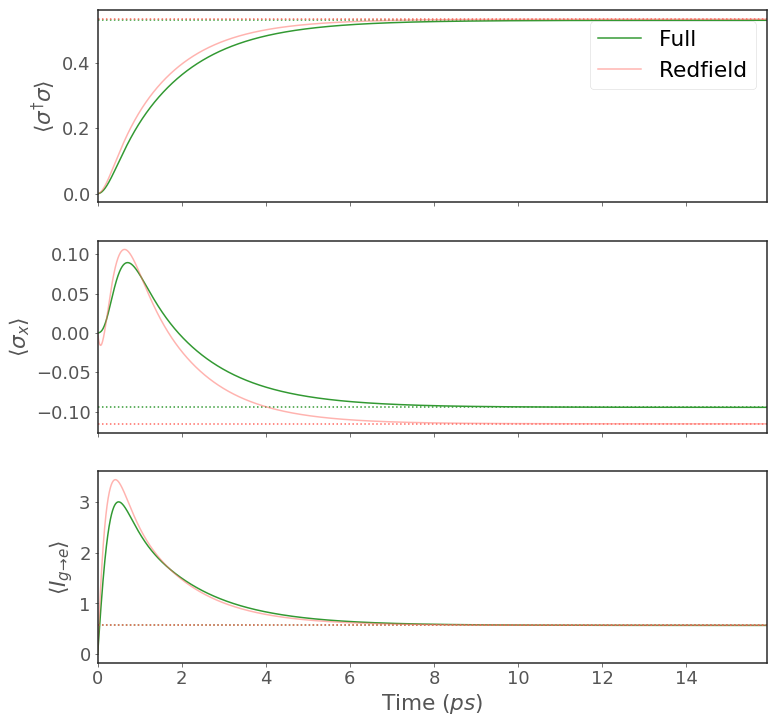

Detuning : 3.0000meV
Dynamics complete


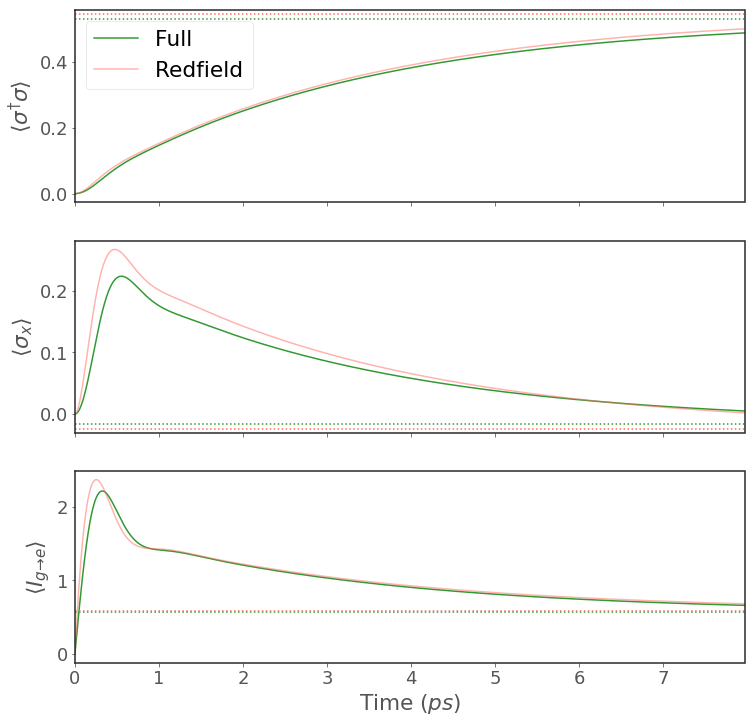

Detuning : 6.0000meV
Dynamics complete


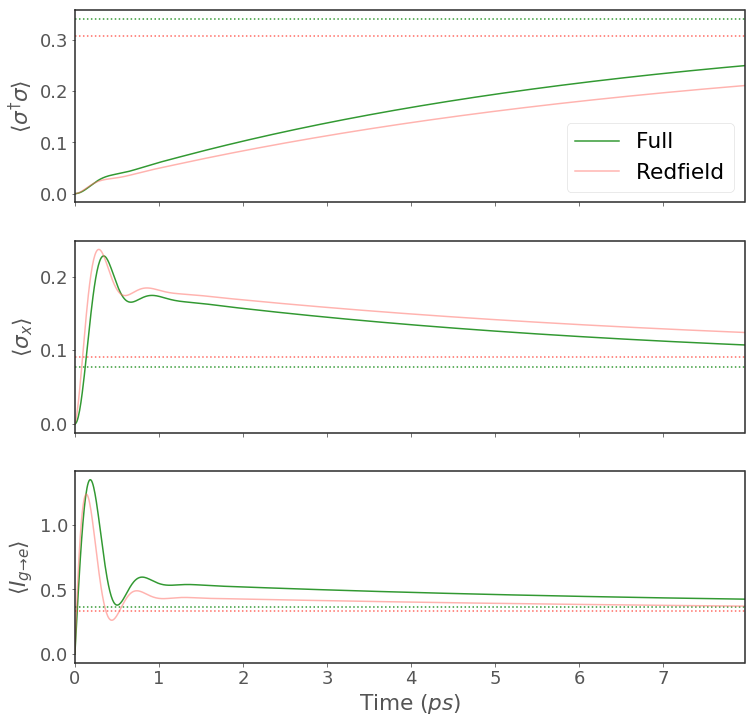

USING N=4
Detuning : 0.0001meV
Dynamics complete


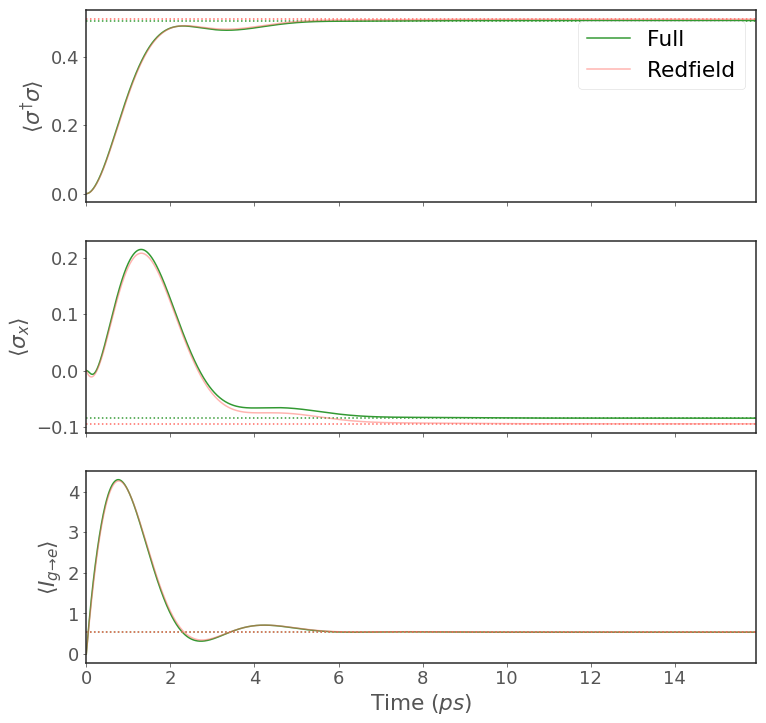

Detuning : 1.0000meV
Dynamics complete


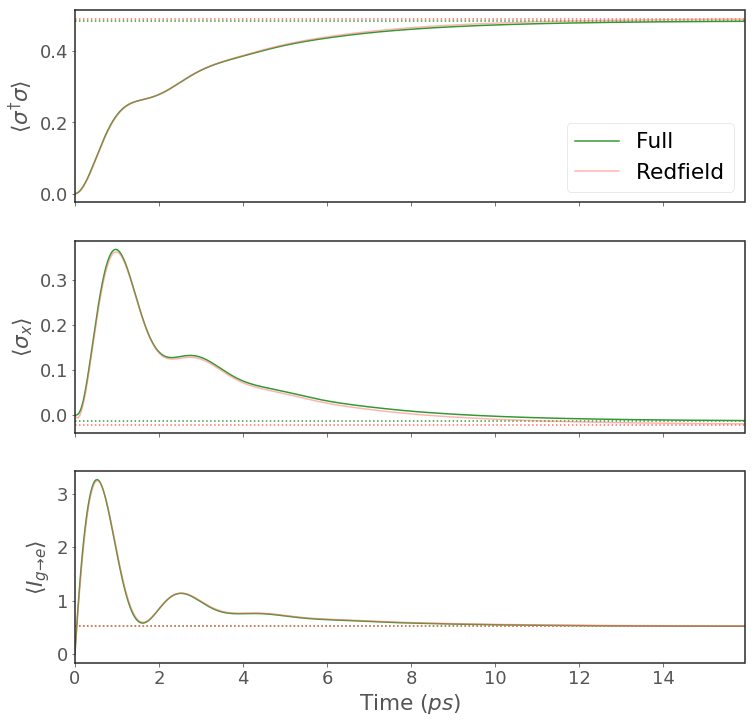

Detuning : 3.0000meV
Dynamics complete


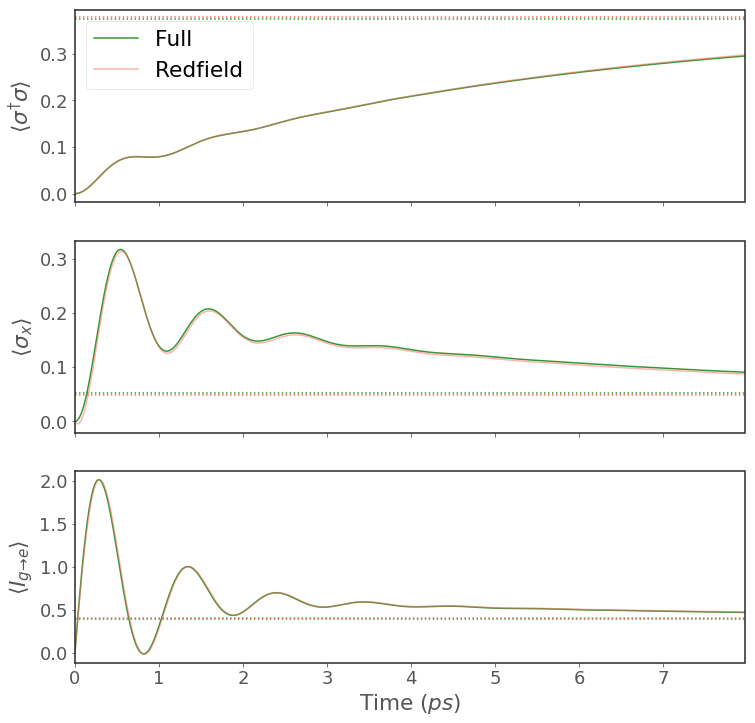

Detuning : 6.0000meV
Dynamics complete


USING N=4
Detuning : 0.0001meV
Dynamics complete


Detuning : 1.0000meV
Dynamics complete


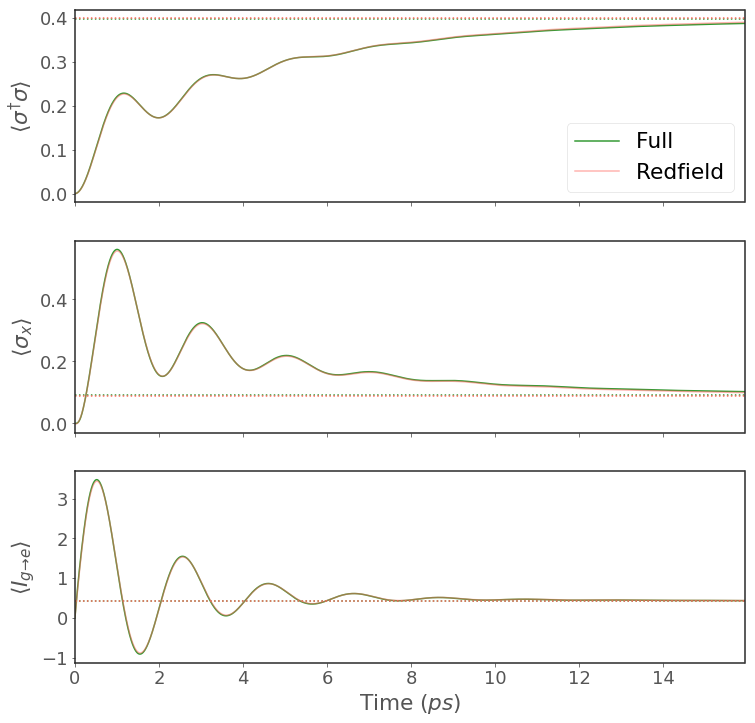

Detuning : 3.0000meV
Dynamics complete


Detuning : 6.0000meV
Dynamics complete


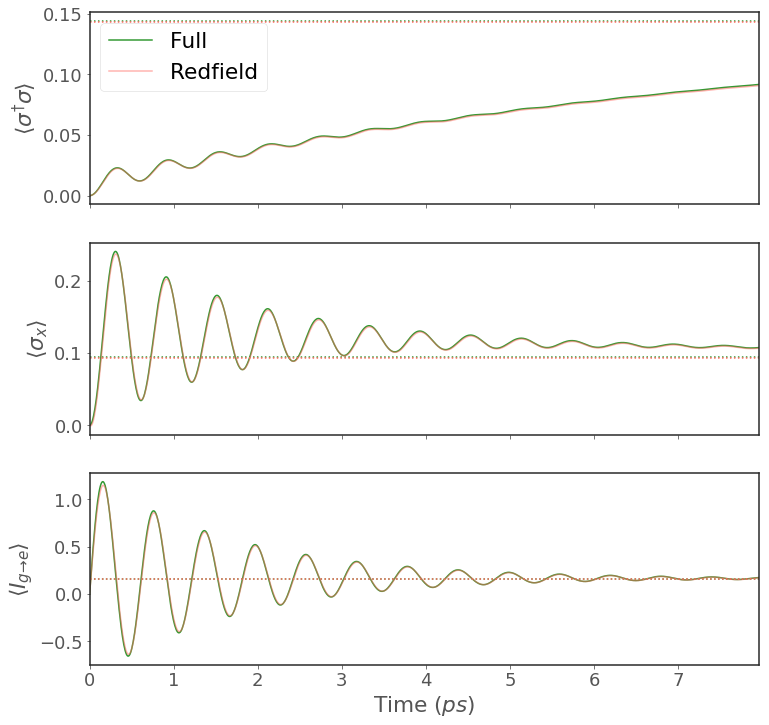

In [12]:
# low T, weak coupling 
T=35
alpha=1e-3
w0 = 6e-3
Gamma = 2*w0
Rabi = 1e-3
tf=3
for w0 in [6e-3, 12e-3, 18e-3]:
    get_data_and_plot_for_detunings(T=T, alpha=alpha, w0=w0, Gamma=Gamma, Rabi = Rabi, tf=tf)

USING N=7
Detuning : 0.0010meV
Dynamics complete


Detuning : 1.0000meV
Dynamics complete


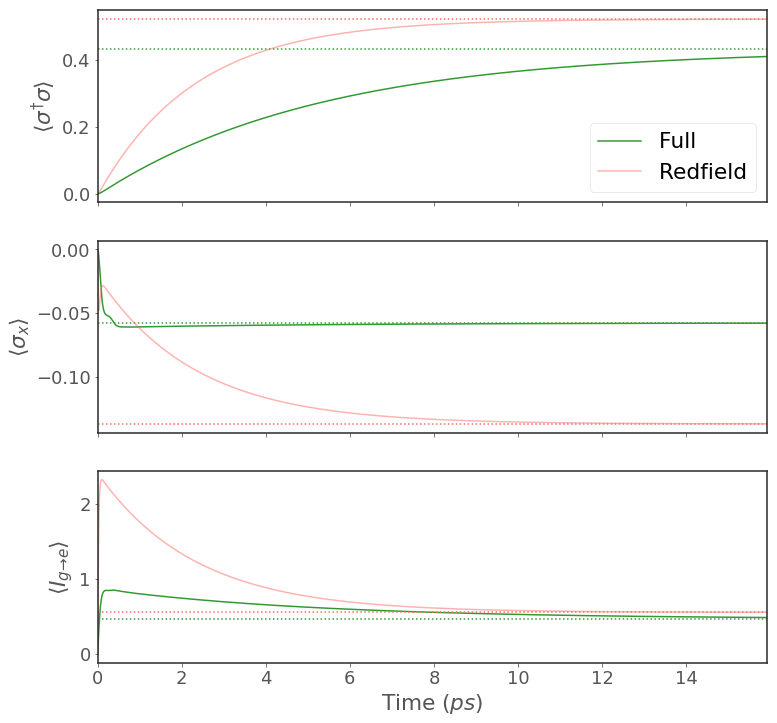

Detuning : 3.0000meV
Dynamics complete


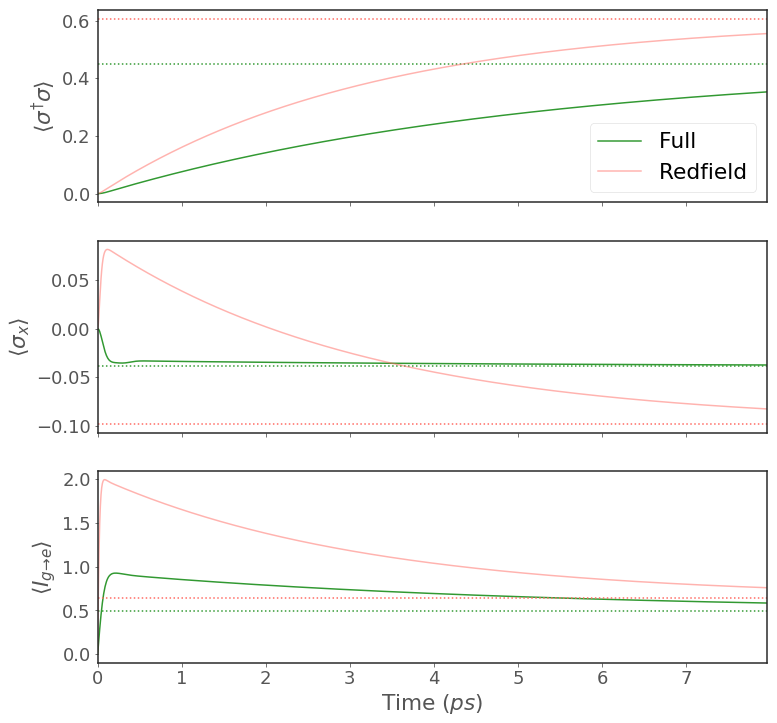

Detuning : 6.0000meV
Dynamics complete


USING N=6
Detuning : 0.0010meV
Dynamics complete


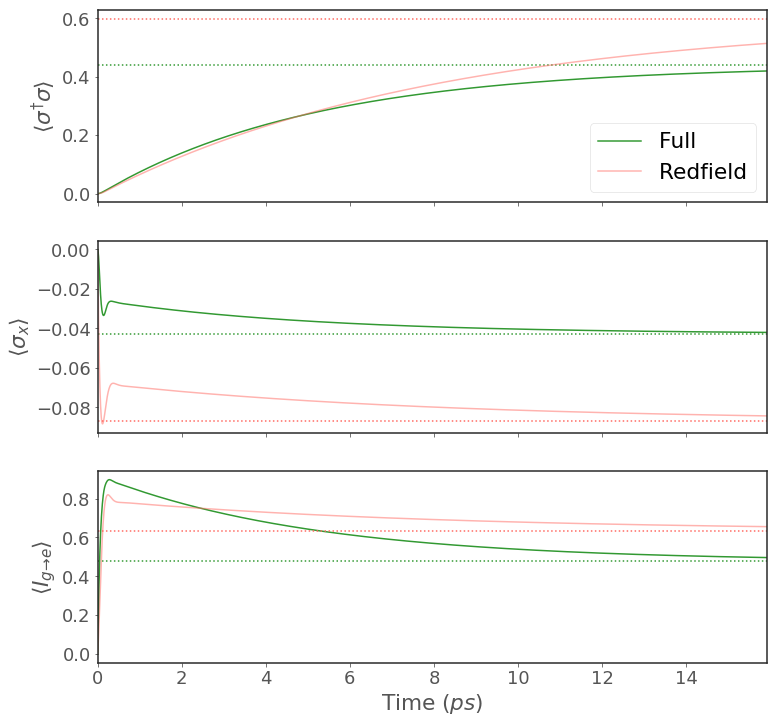

Detuning : 1.0000meV
Dynamics complete


Detuning : 3.0000meV
Dynamics complete


Detuning : 6.0000meV
Dynamics complete


USING N=5
Detuning : 0.0010meV
Dynamics complete


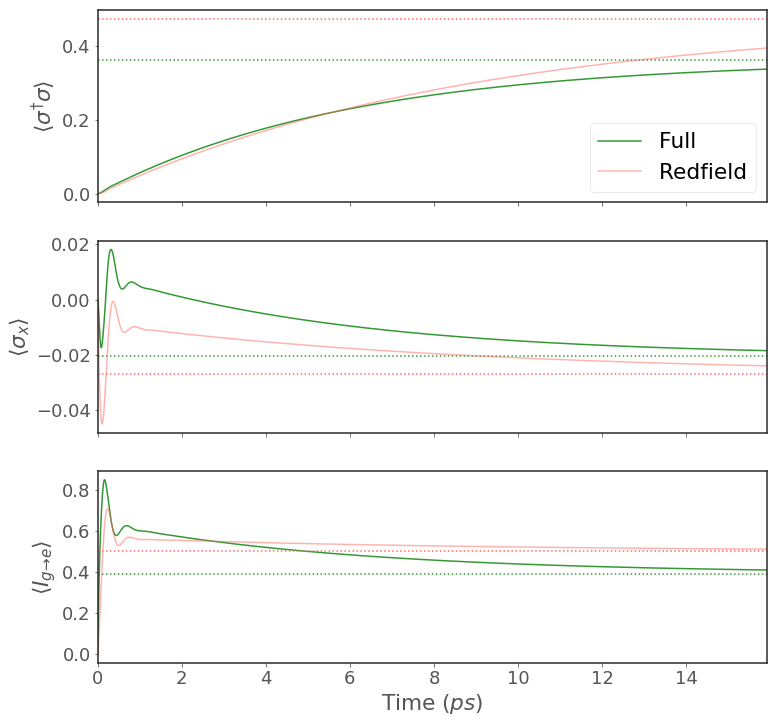

Detuning : 1.0000meV
Dynamics complete


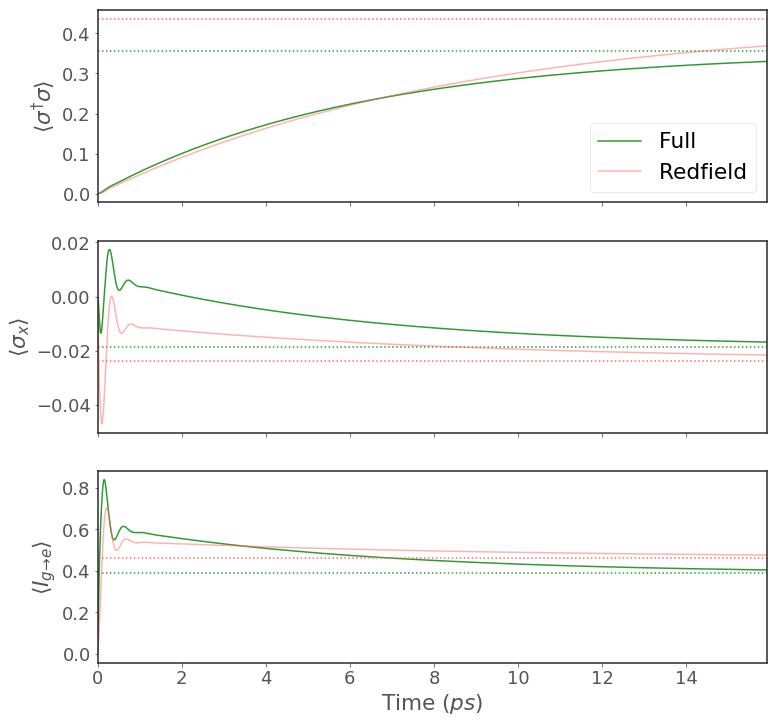

Detuning : 3.0000meV
Dynamics complete


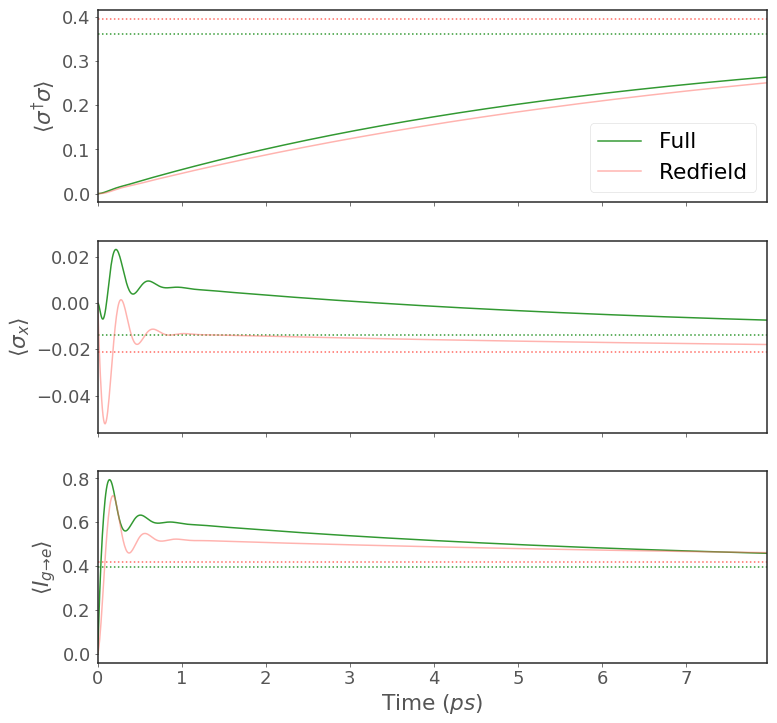

Detuning : 6.0000meV
Dynamics complete


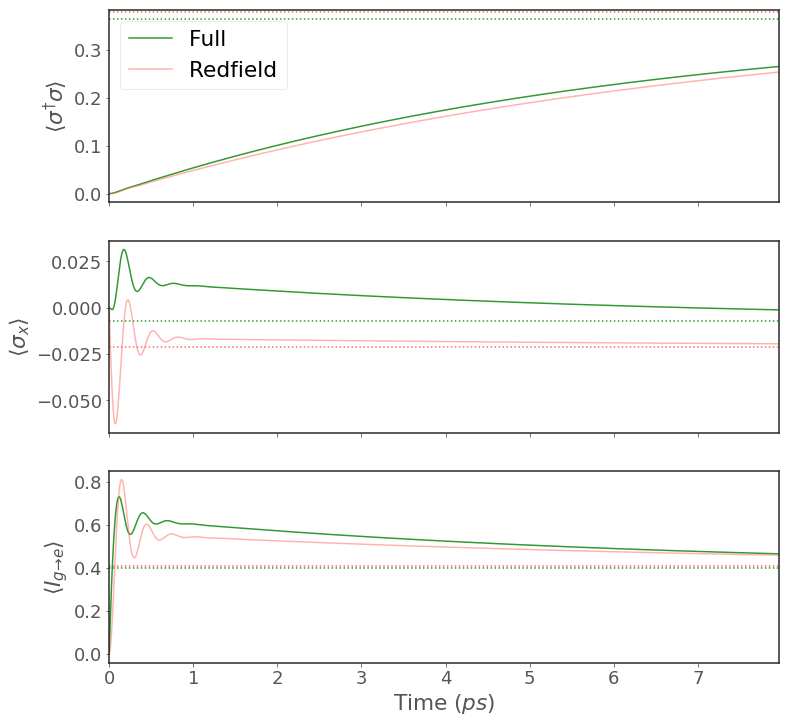

In [13]:
# low T, intermediate coupling 
T=35
alpha=10e-3
w0 = 6e-3
Gamma = 2*w0
Rabi = 1e-3
tf=3
for w0 in [6e-3, 12e-3, 18e-3]:
    get_data_and_plot_for_detunings(T=T, alpha=alpha, w0=w0, Gamma=Gamma, Rabi = Rabi, tf=tf)


USING N=6
Detuning : 0.0001meV
Dynamics complete


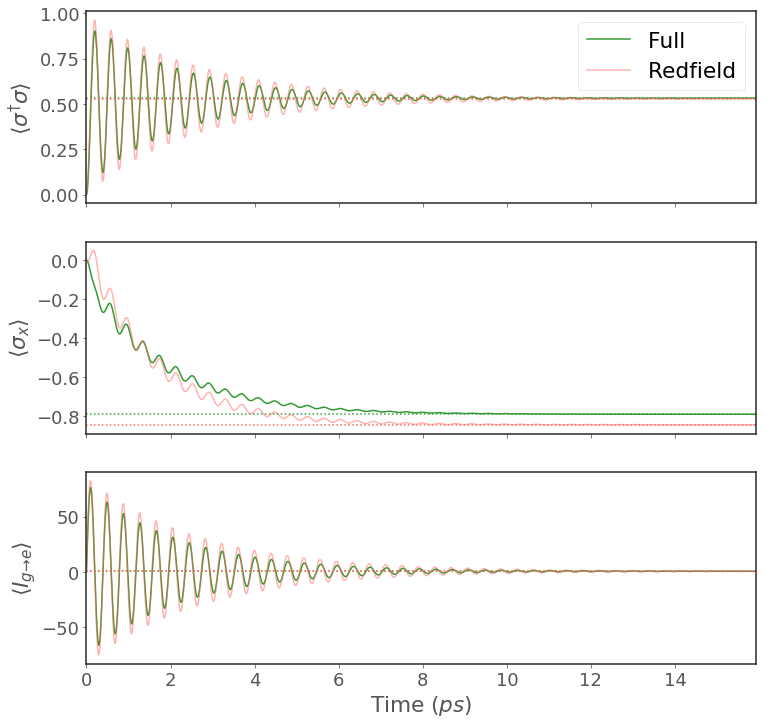

Detuning : 1.0000meV
Dynamics complete


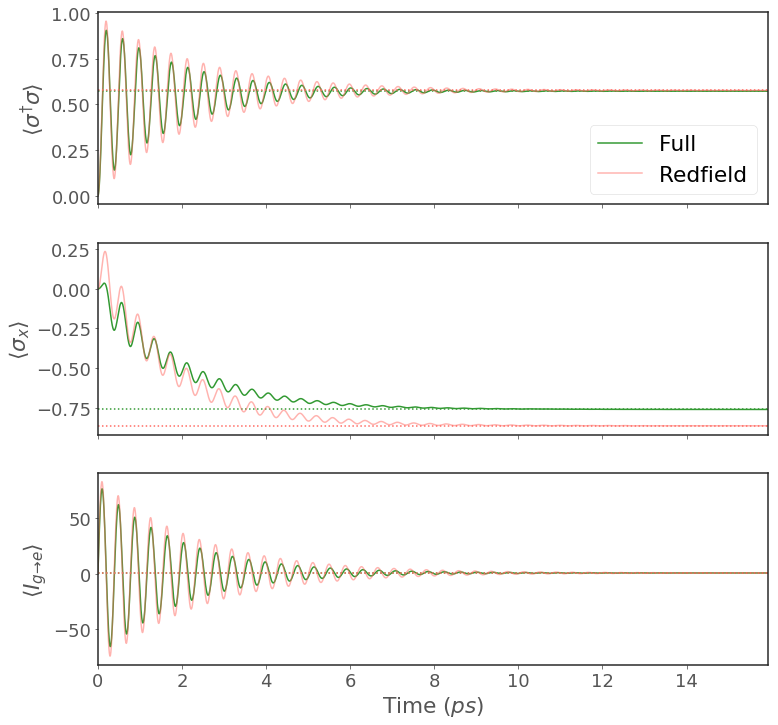

Detuning : 3.0000meV
Dynamics complete


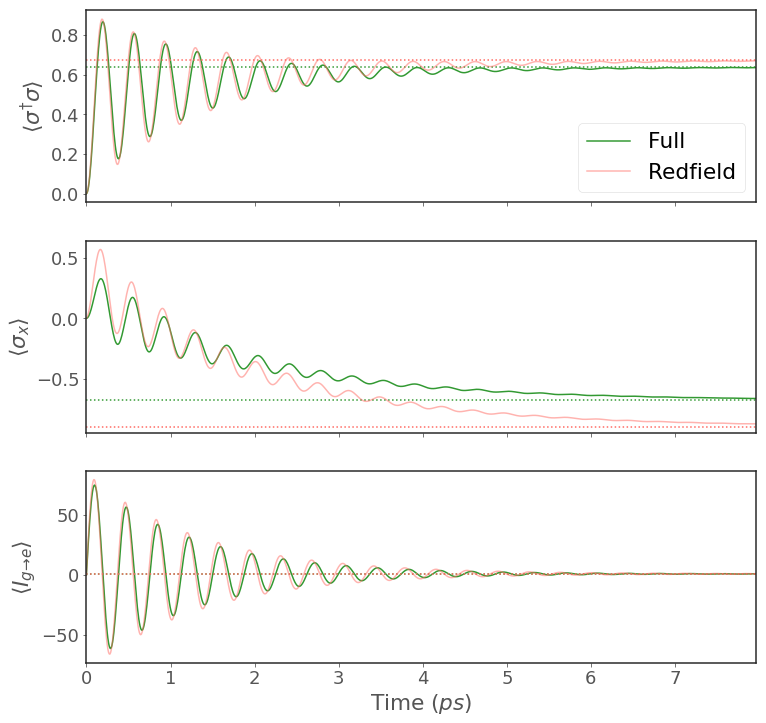

Detuning : 6.0000meV
Dynamics complete


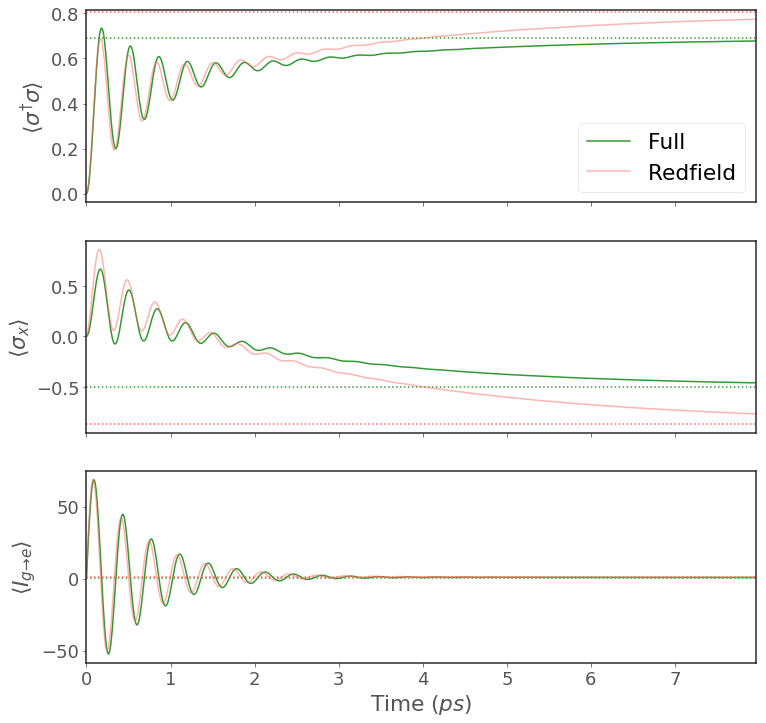

USING N=4
Detuning : 0.0001meV
Dynamics complete


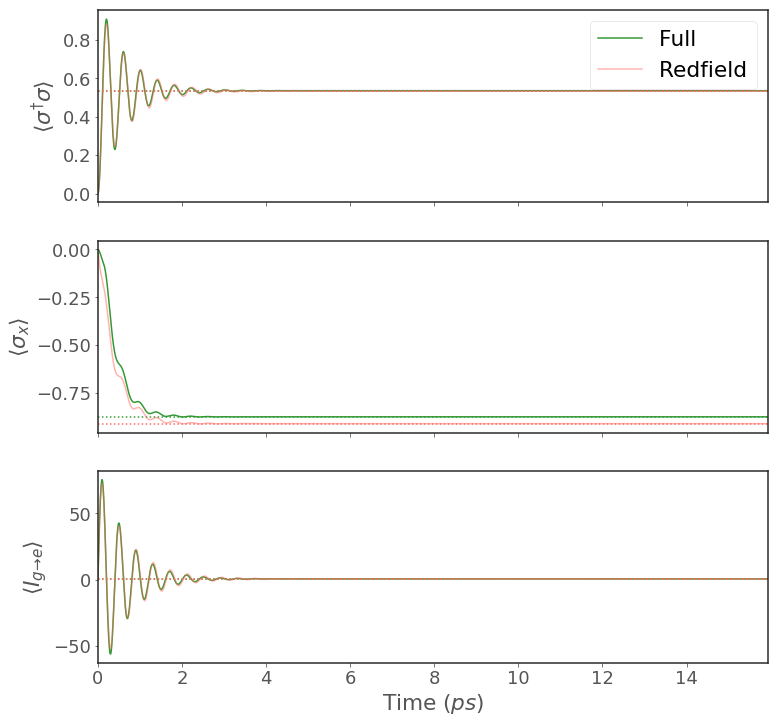

Detuning : 1.0000meV
Dynamics complete


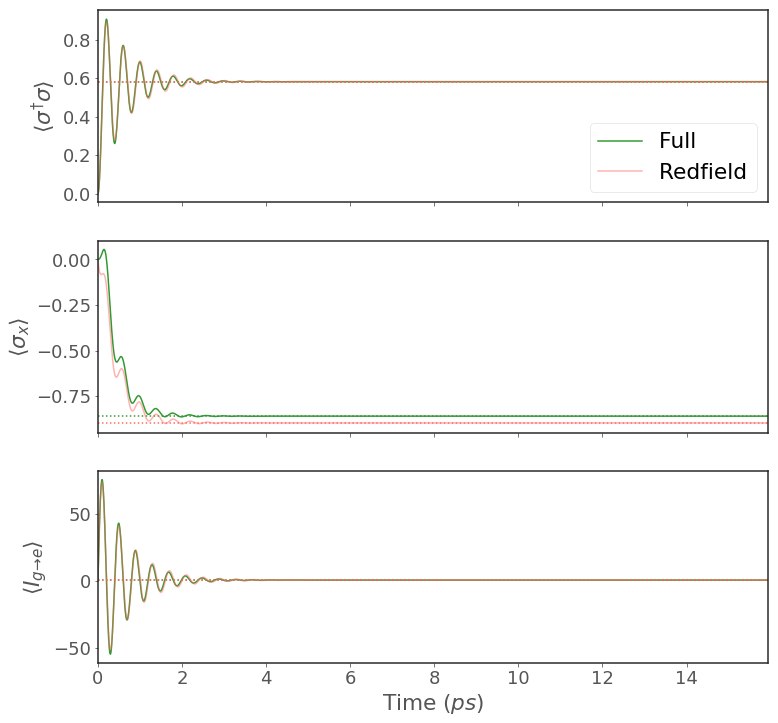

Detuning : 3.0000meV
Dynamics complete


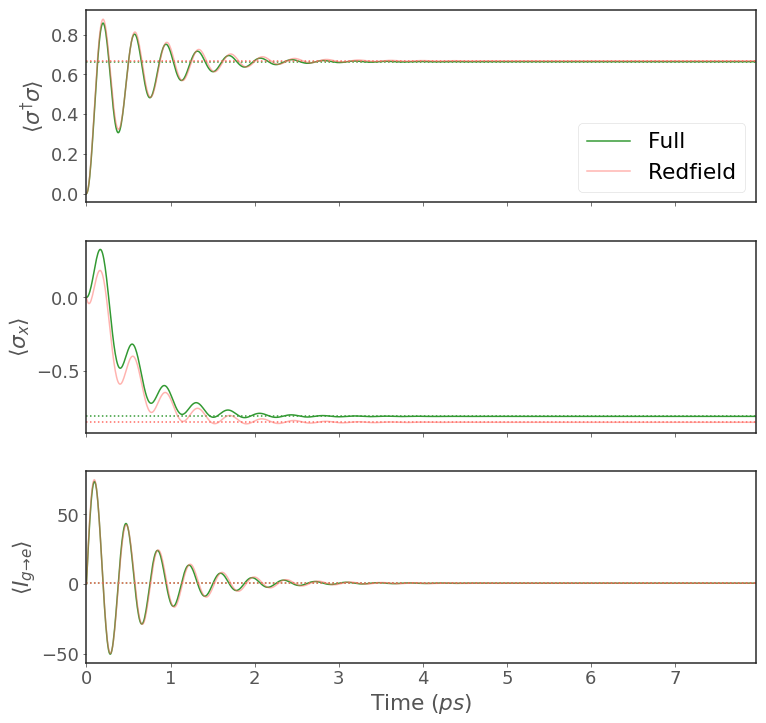

Detuning : 6.0000meV
Dynamics complete


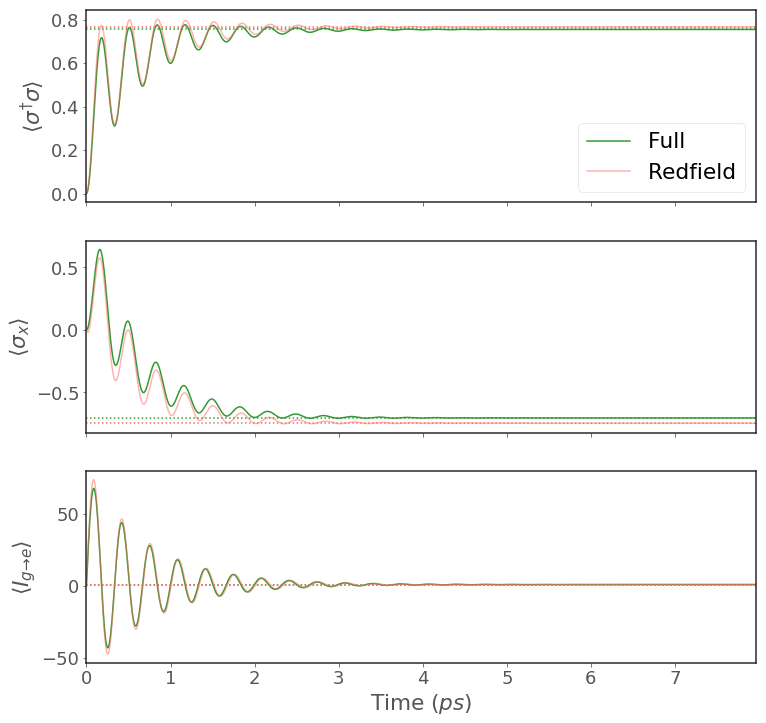

USING N=4
Detuning : 0.0001meV
Dynamics complete


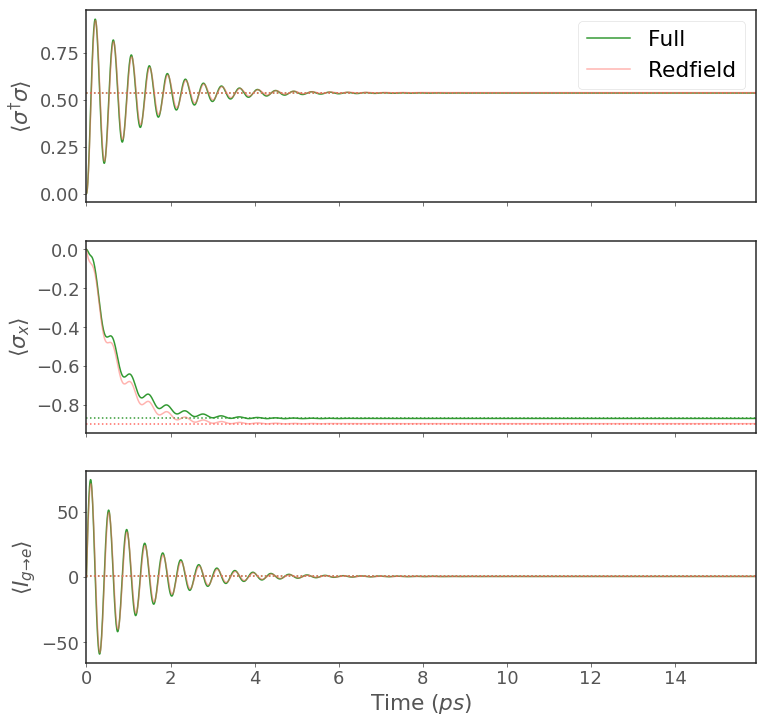

Detuning : 1.0000meV
Dynamics complete


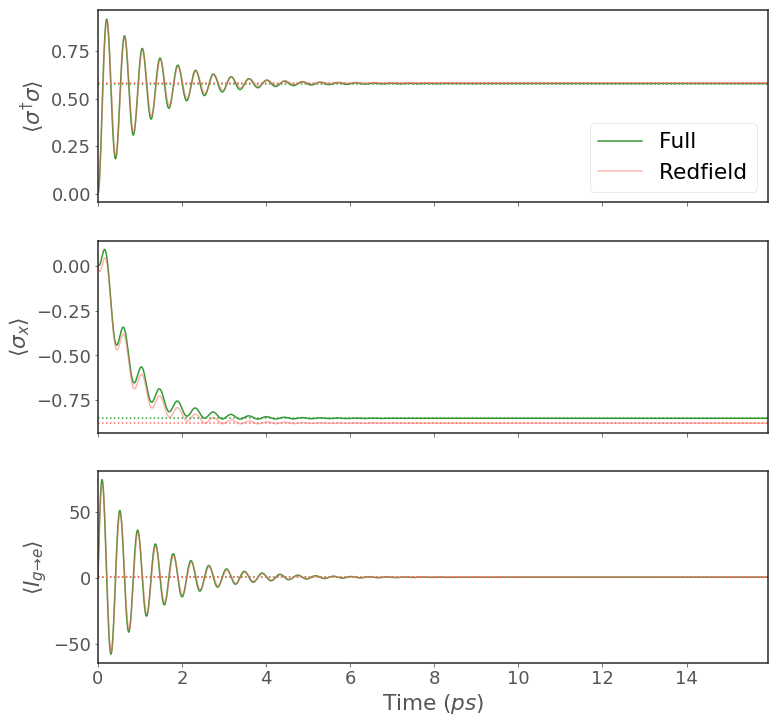

Detuning : 3.0000meV
Dynamics complete


Detuning : 6.0000meV
Dynamics complete


In [14]:
# low T, intermediate Rabi 
T=35
alpha=1e-3
w0 = 6e-3
Gamma = 2*w0
Rabi = 10e-3
tf=3
for w0 in [6e-3, 12e-3, 18e-3]:
    get_data_and_plot_for_detunings(T=T, alpha=alpha, w0=w0, Gamma=Gamma, Rabi = Rabi, tf=tf)

USING N=6
Detuning : 0.0001meV
Dynamics complete


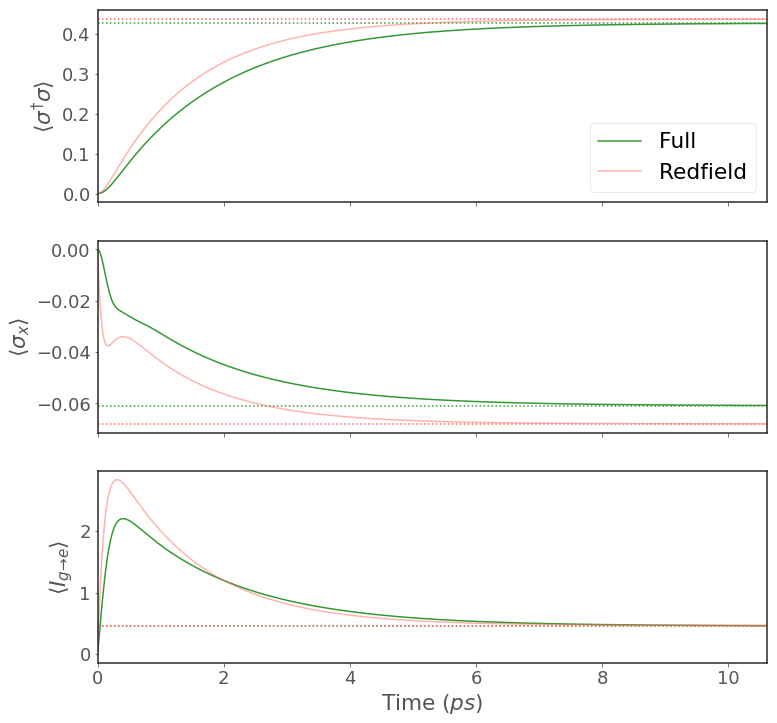

Detuning : 1.0000meV
Dynamics complete


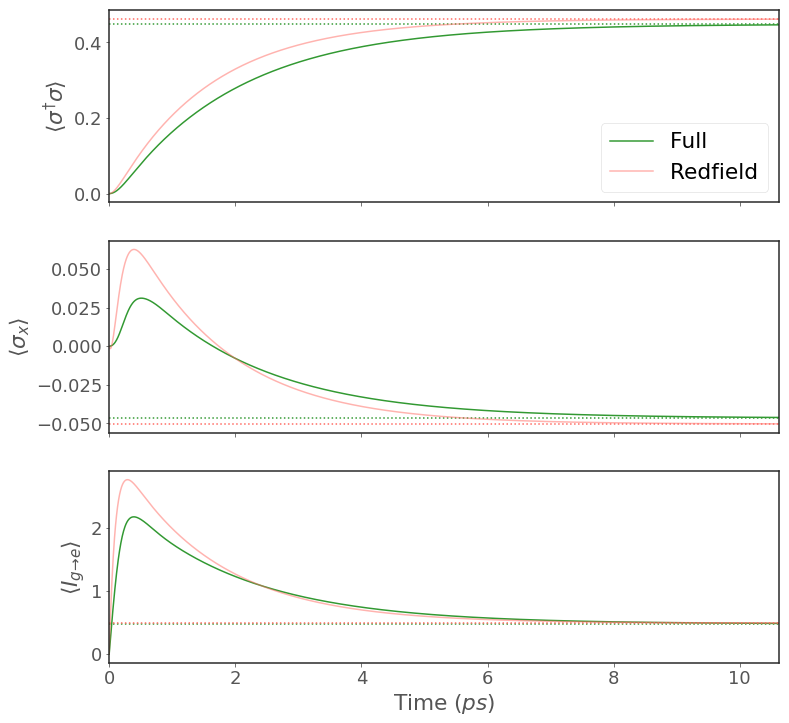

Detuning : 3.0000meV
Dynamics complete


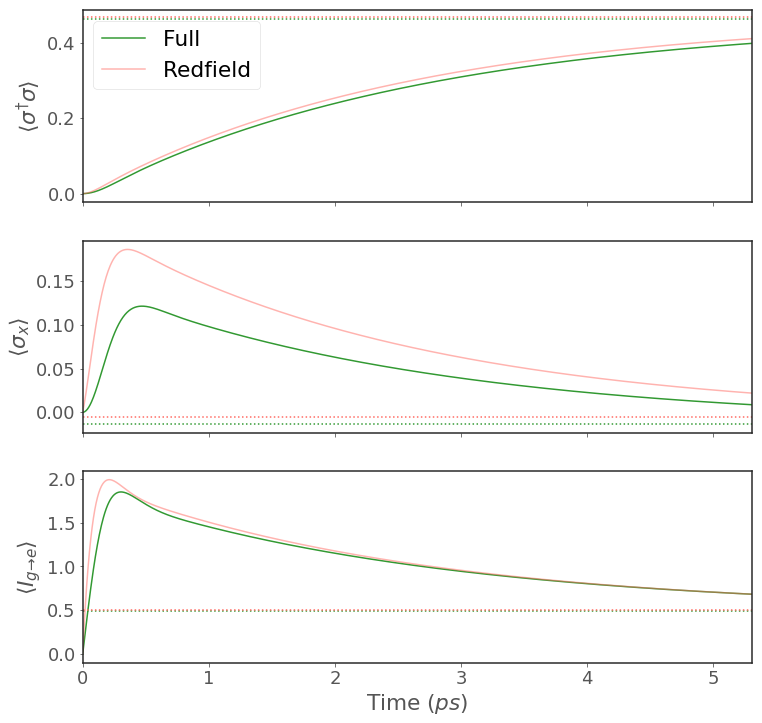

Detuning : 6.0000meV
Dynamics complete


USING N=6
Detuning : 0.0001meV
Dynamics complete


Detuning : 1.0000meV
Dynamics complete


Detuning : 3.0000meV
Dynamics complete


Detuning : 6.0000meV
Dynamics complete


USING N=6
Detuning : 0.0001meV
Dynamics complete


Detuning : 1.0000meV
Dynamics complete


Detuning : 3.0000meV
Dynamics complete


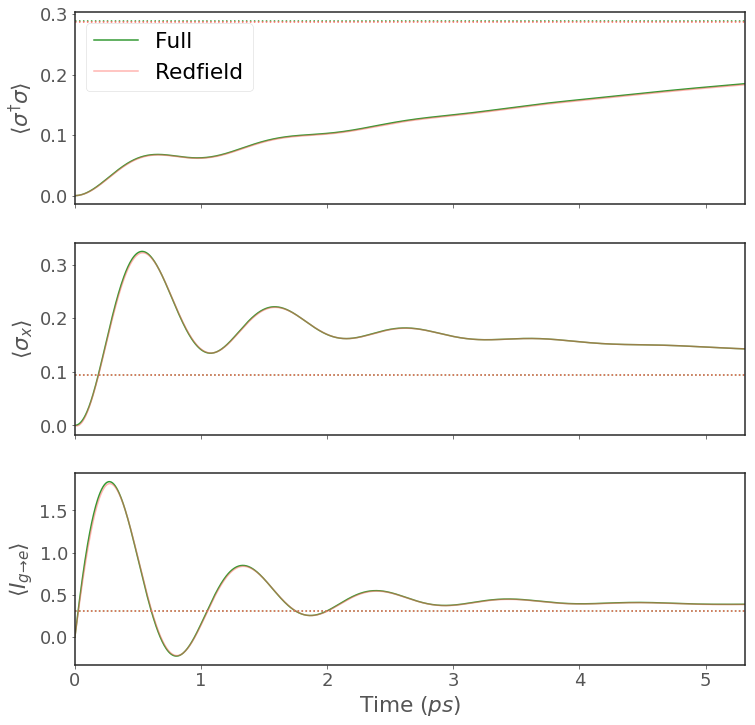

Detuning : 6.0000meV
Dynamics complete


In [15]:
# higher T, weak coupling
T=77
alpha = 1e-3
Gamma = 12e-3
Rabi = 1e-3
tf=2
for w0 in [6e-3, 12e-3, 18e-3]:
    get_data_and_plot_for_detunings(T=T, alpha=alpha, w0=w0, Gamma=Gamma, Rabi = Rabi, tf=tf)

USING N=9
Detuning : 0.0010meV
Dynamics complete


Detuning : 1.0000meV
Dynamics complete


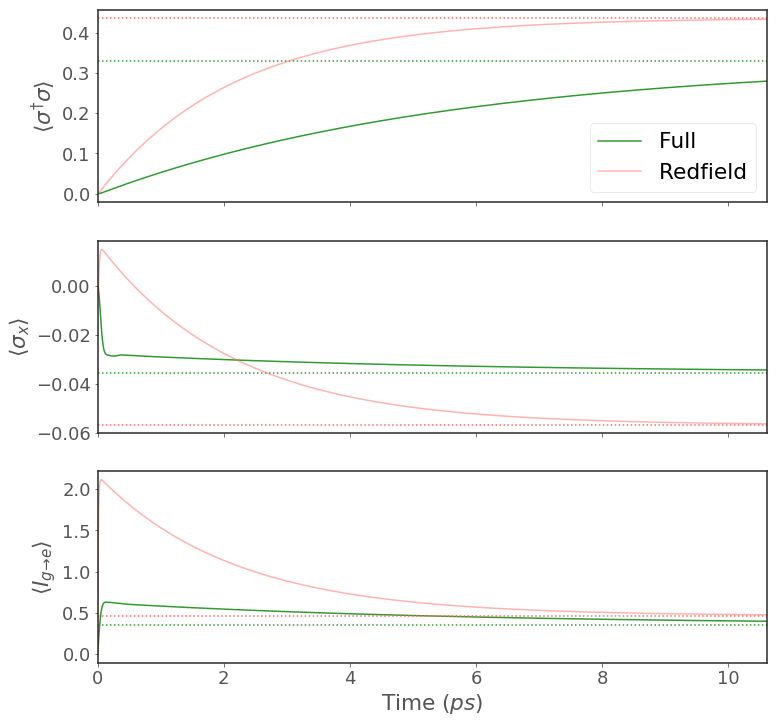

Detuning : 3.0000meV
Dynamics complete


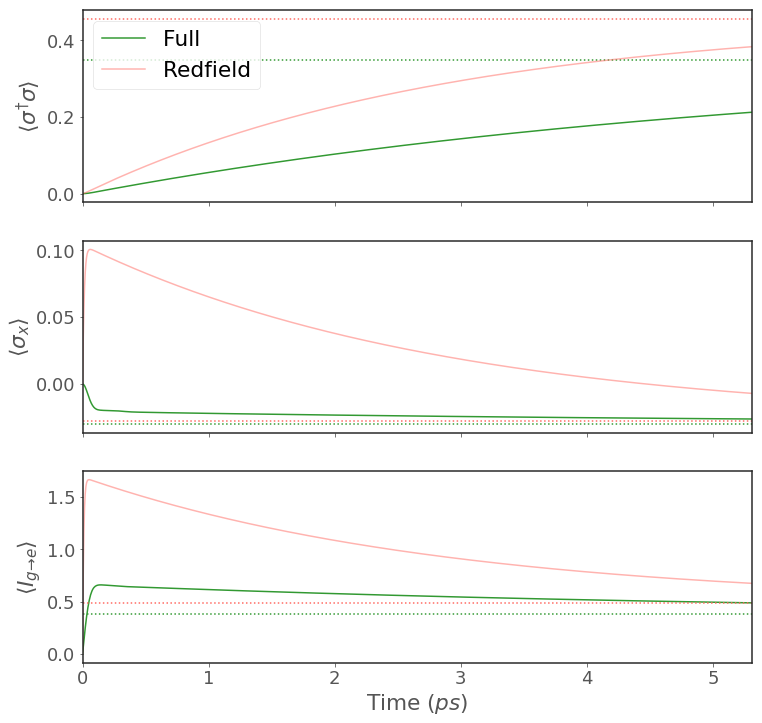

Detuning : 6.0000meV
Dynamics complete


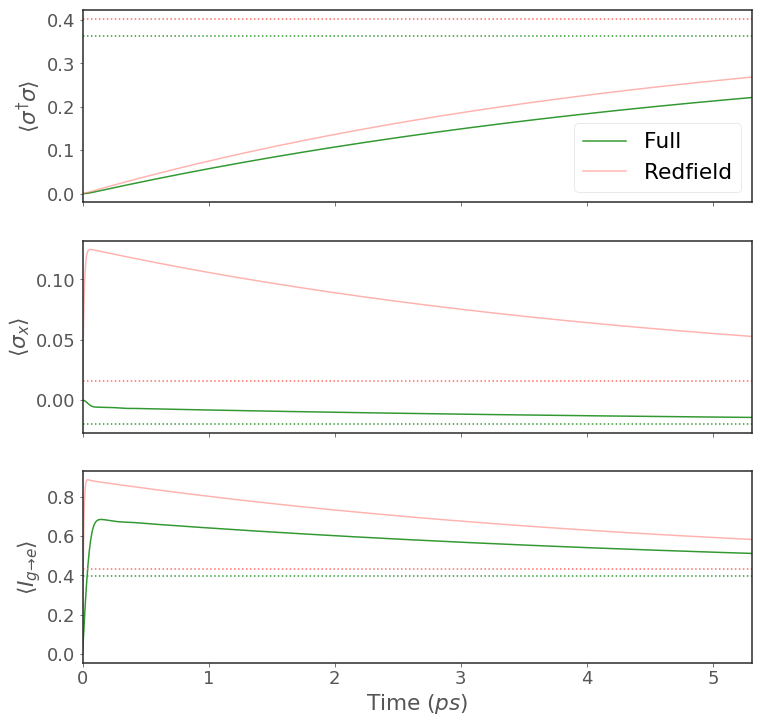

USING N=7
Detuning : 0.0010meV
Dynamics complete


Detuning : 1.0000meV
Dynamics complete


Detuning : 3.0000meV
Dynamics complete


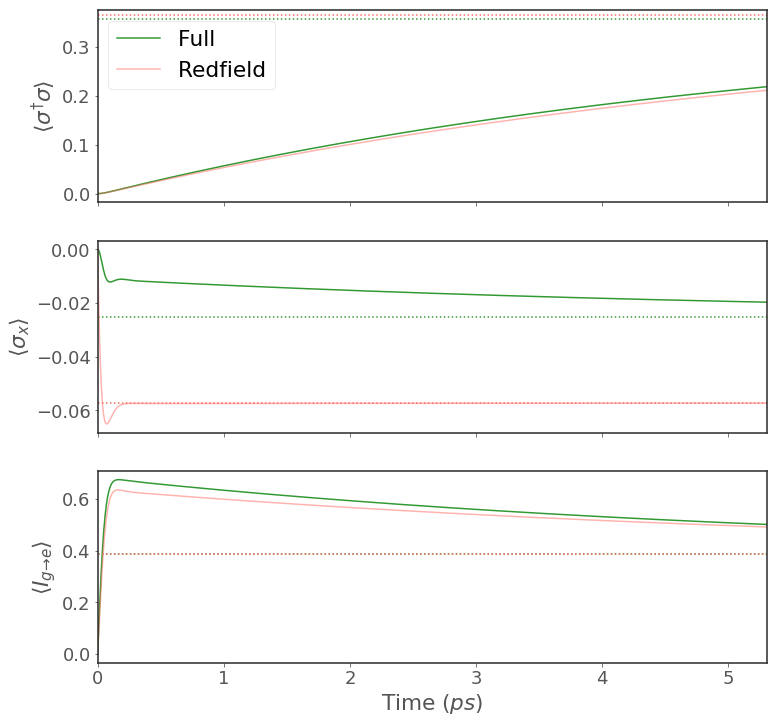

Detuning : 6.0000meV
Dynamics complete


USING N=7
Detuning : 0.0010meV
Dynamics complete


Detuning : 1.0000meV
Dynamics complete


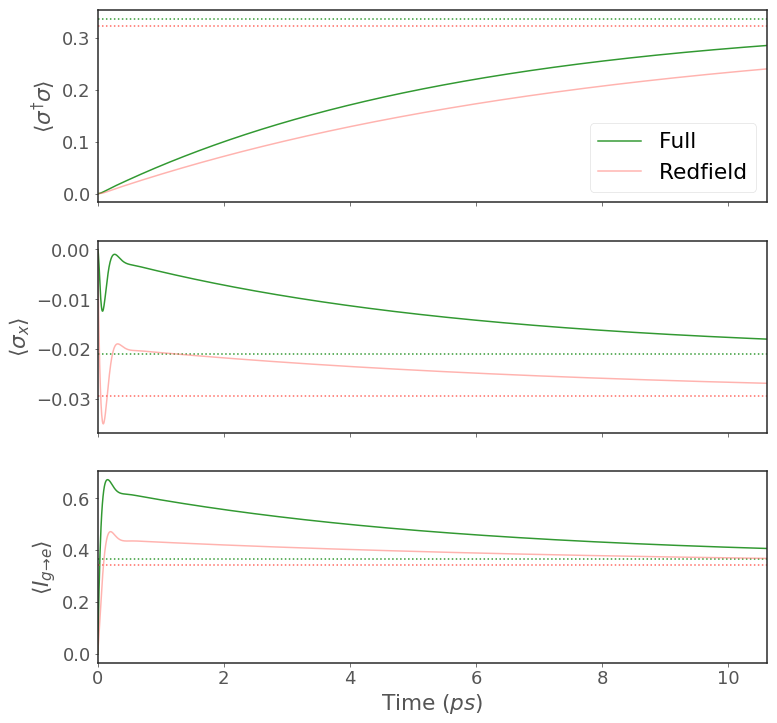

Detuning : 3.0000meV
Dynamics complete


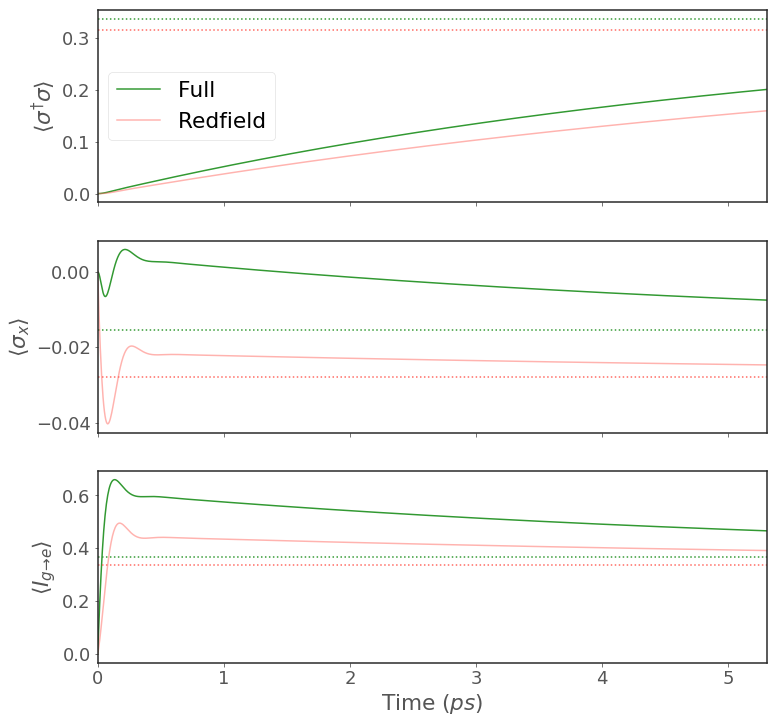

Detuning : 6.0000meV
Dynamics complete


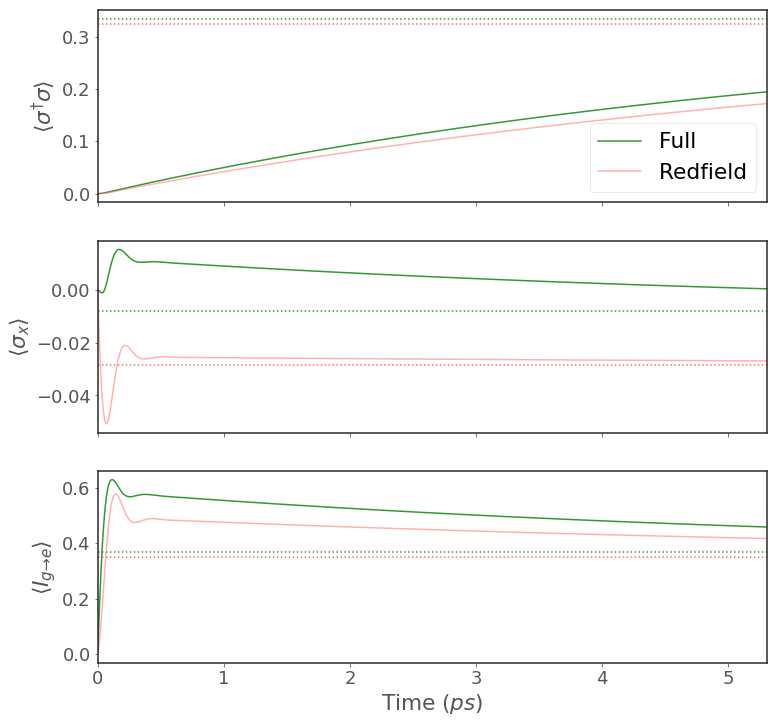

In [16]:
# higher T, intermediate coupling
T=77
alpha=10e-3
Gamma = 12e-3
Rabi = 1e-3
tf=2
for w0 in [6e-3, 12e-3, 18e-3]:
    get_data_and_plot_for_detunings(T=T, alpha=alpha, w0=w0, Gamma=Gamma, Rabi = Rabi, tf=tf)

USING N=6
Detuning : 0.0001meV
Dynamics complete


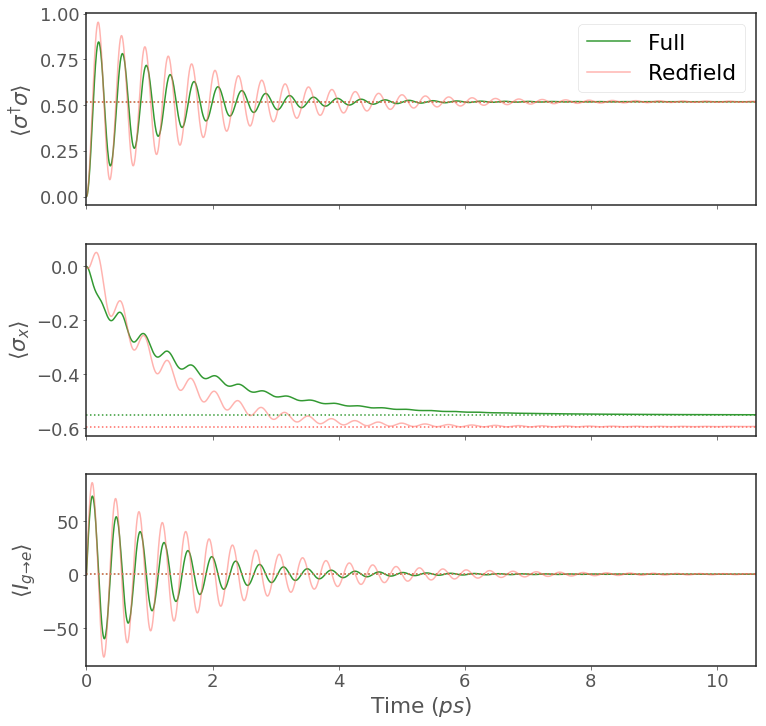

Detuning : 1.0000meV
Dynamics complete


Detuning : 3.0000meV
Dynamics complete


Detuning : 6.0000meV
Dynamics complete


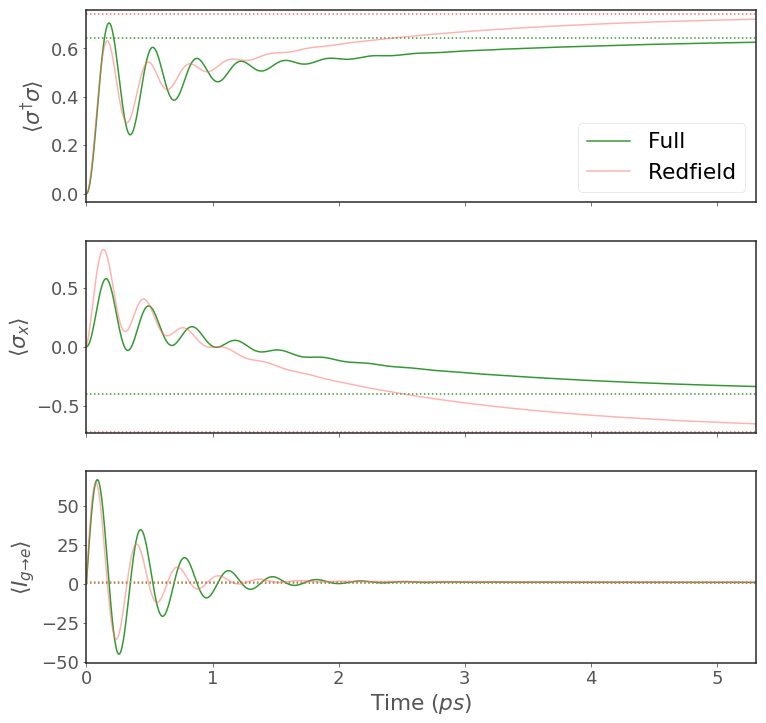

USING N=6
Detuning : 0.0001meV
Dynamics complete


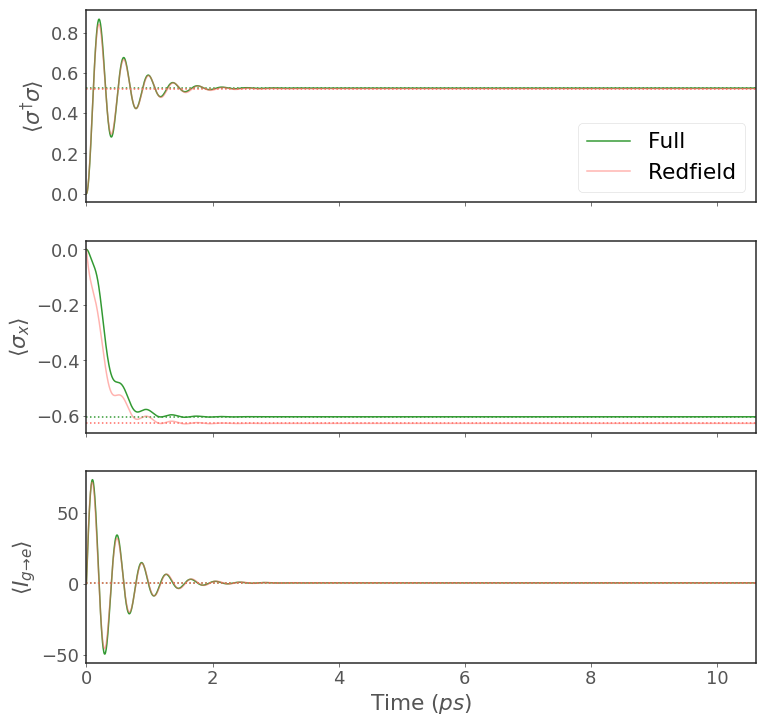

Detuning : 1.0000meV
Dynamics complete


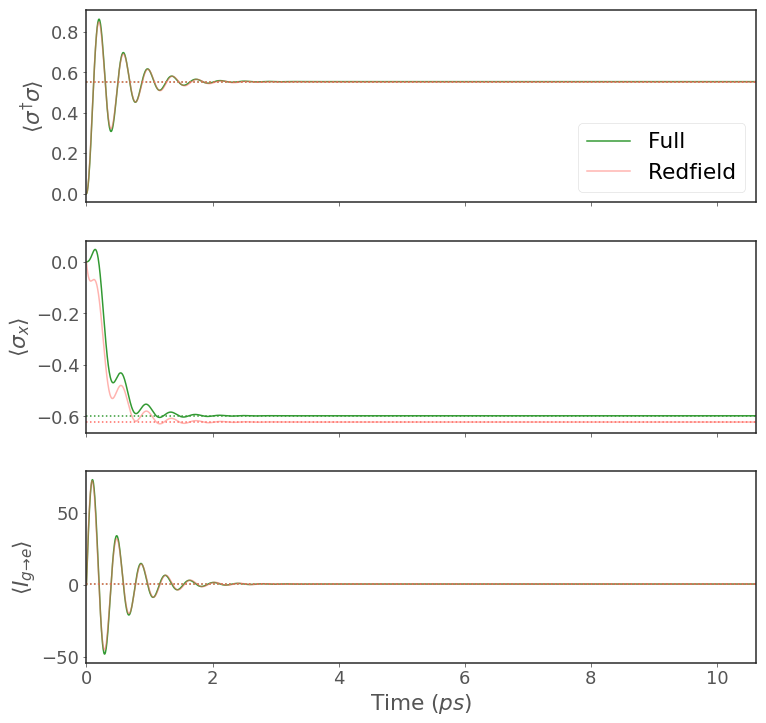

Detuning : 3.0000meV
Dynamics complete


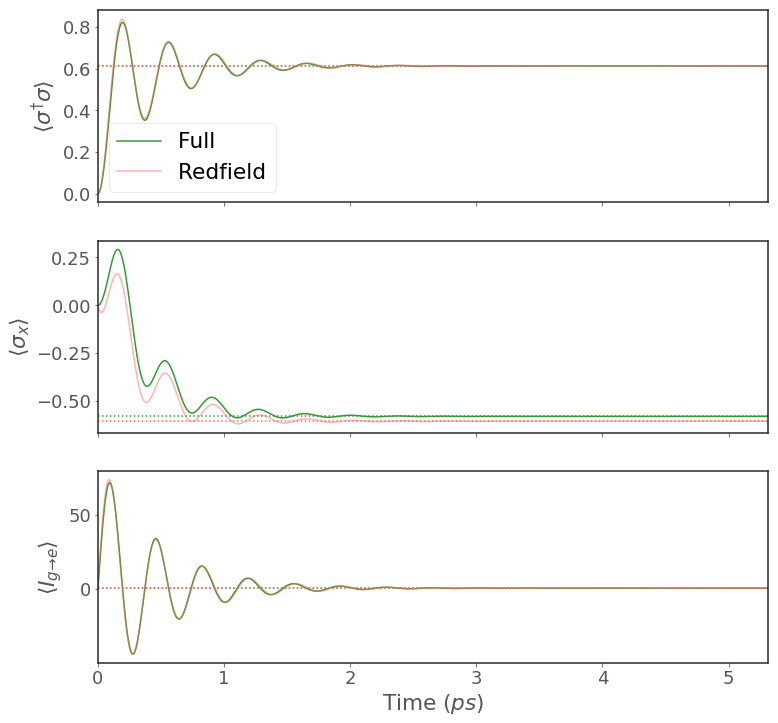

Detuning : 6.0000meV
Dynamics complete


USING N=6
Detuning : 0.0001meV
Dynamics complete


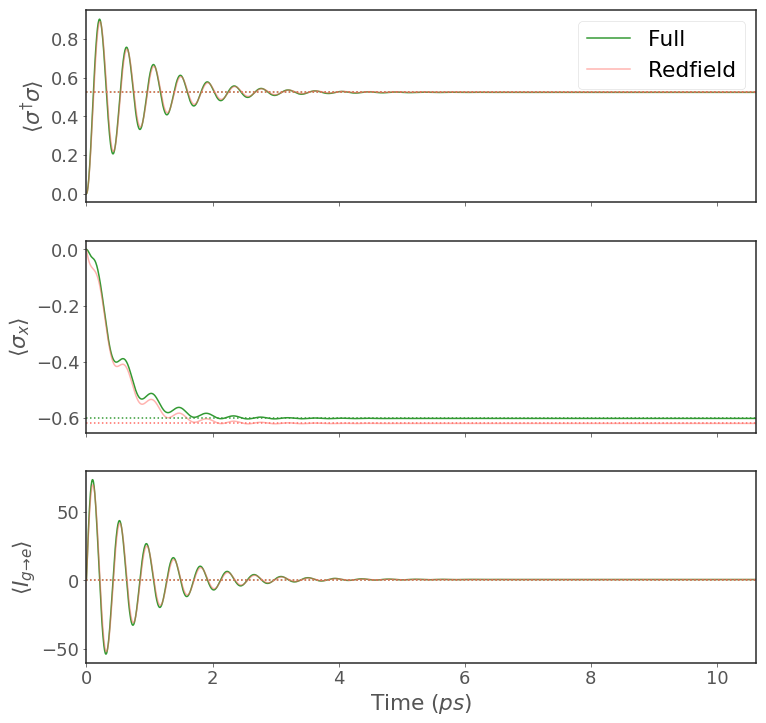

Detuning : 1.0000meV
Dynamics complete


Detuning : 3.0000meV
Dynamics complete


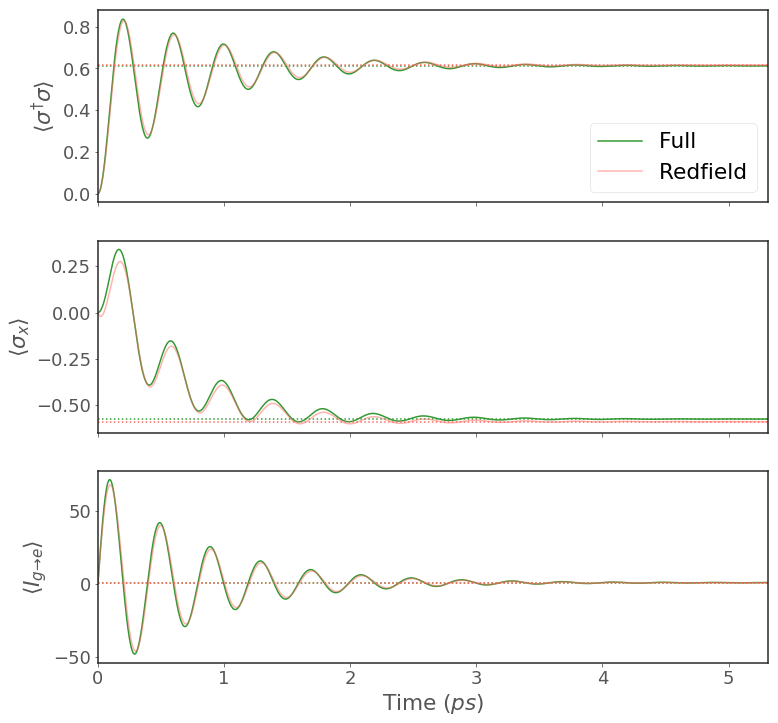

Detuning : 6.0000meV
Dynamics complete


In [17]:
# higher T, intermediate Rabi
T=77
alpha=1e-3
Gamma = 12e-3
Rabi = 10e-3
tf=2
for w0 in [6e-3, 12e-3, 18e-3]:
    get_data_and_plot_for_detunings(T=T, alpha=alpha, w0=w0, Gamma=Gamma, Rabi = Rabi, tf=tf)

Error could only converge to 0.3037556590631927
USING N=6
Detuning : 0.0001meV
Dynamics complete


Detuning : 1.0000meV
Dynamics complete


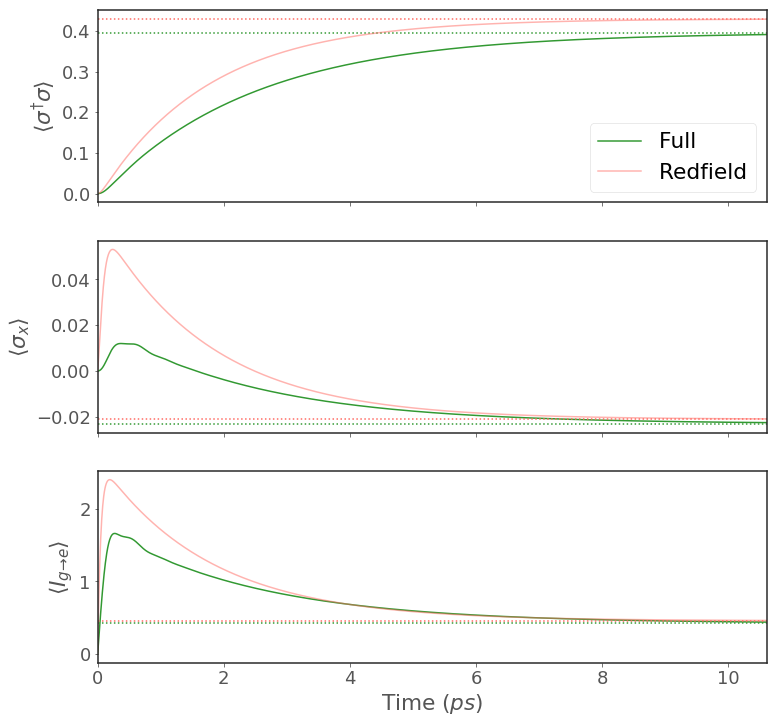

Detuning : 3.0000meV
Dynamics complete


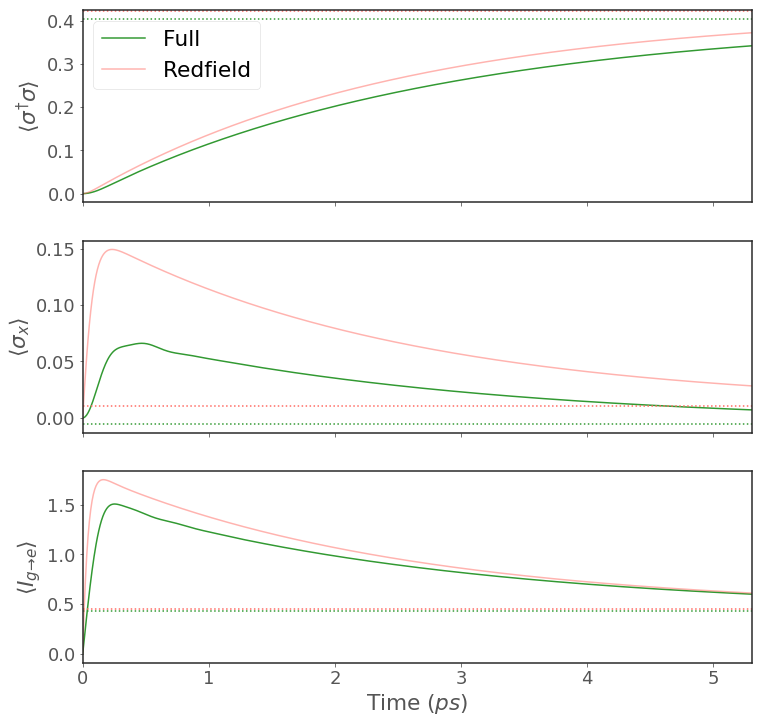

Detuning : 6.0000meV
Dynamics complete


USING N=6
Detuning : 0.0001meV
Dynamics complete


Detuning : 1.0000meV
Dynamics complete


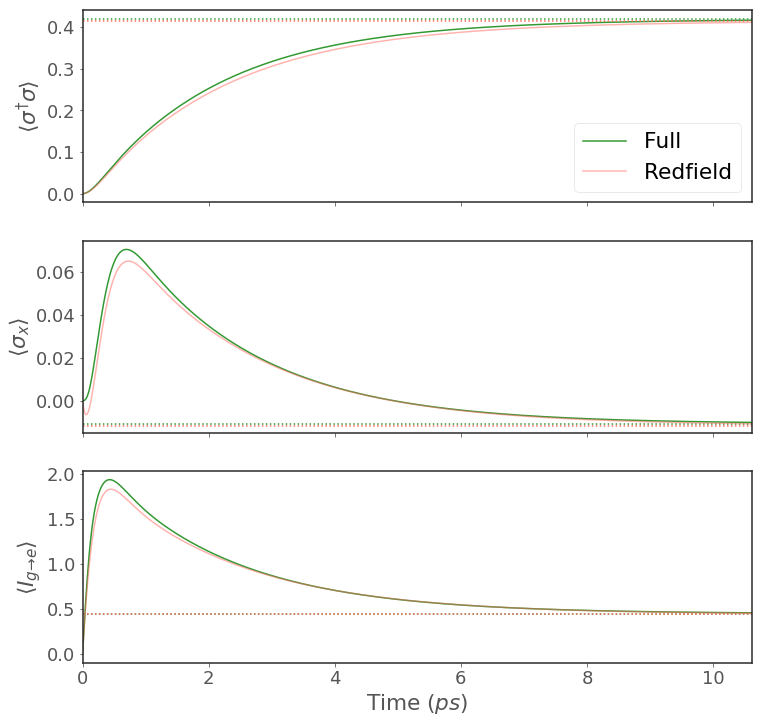

Detuning : 3.0000meV
Dynamics complete


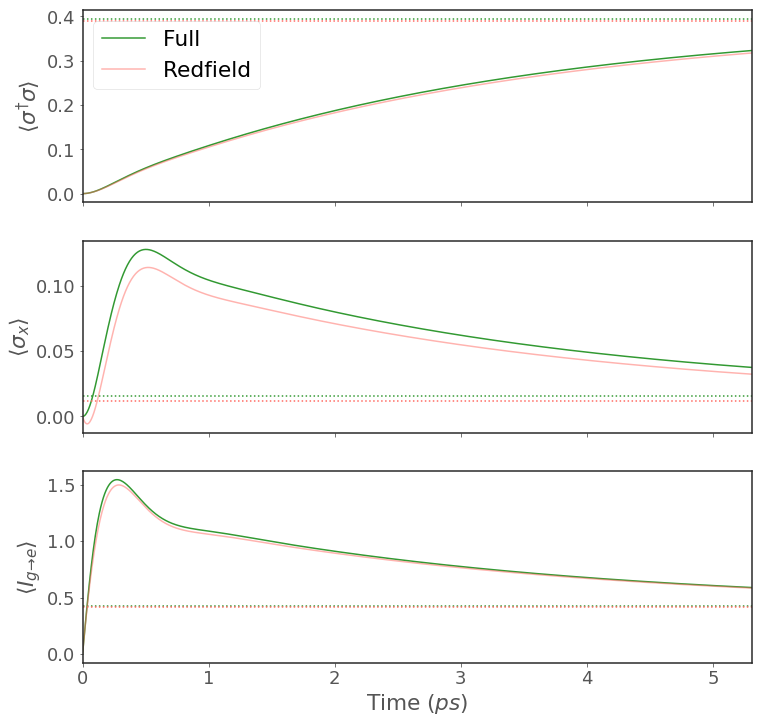

Detuning : 6.0000meV
Dynamics complete


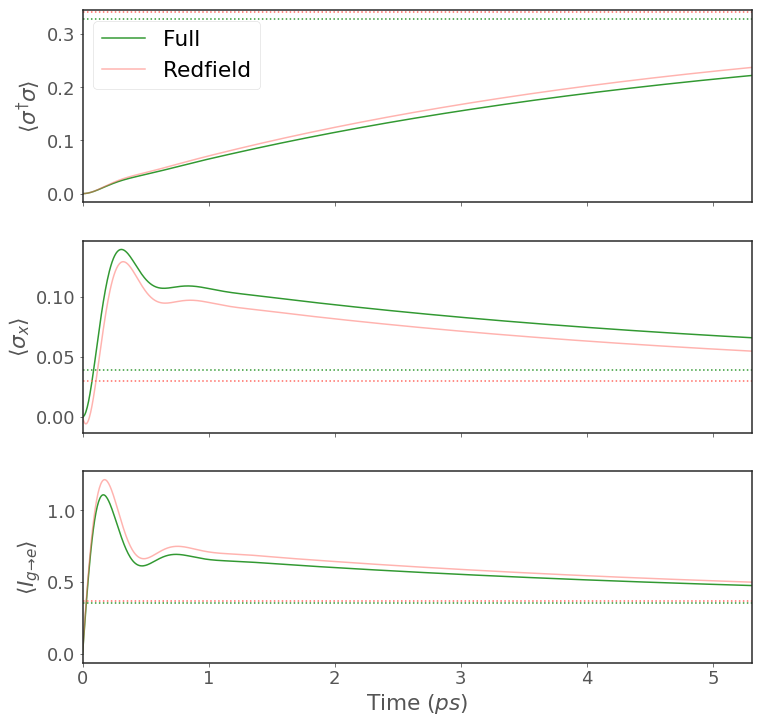

USING N=6
Detuning : 0.0001meV
Dynamics complete


Detuning : 1.0000meV
Dynamics complete


Detuning : 3.0000meV
Dynamics complete


Detuning : 6.0000meV
Dynamics complete


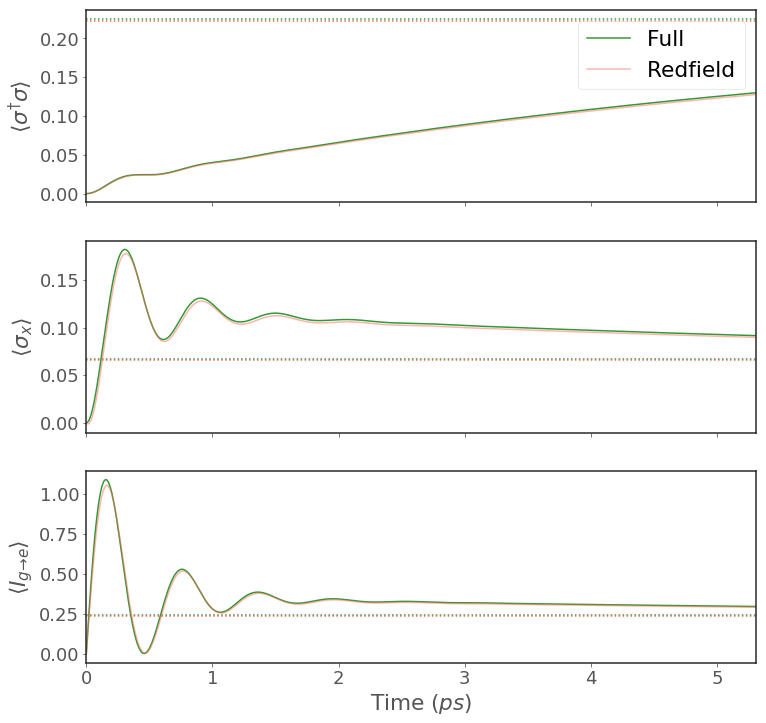

In [18]:
# highest T, weak coupling
T=150
alpha=1e-3
Gamma = 12e-3
Rabi = 1e-3
tf=2
for w0 in [6e-3, 12e-3, 18e-3]:
    get_data_and_plot_for_detunings(T=T, alpha=alpha, w0=w0, Gamma=Gamma, Rabi = Rabi, tf=tf, wc_tol=1e-6)

Error could only converge to 0.8262187983205777
USING N=9
Detuning : 0.0010meV
Dynamics complete


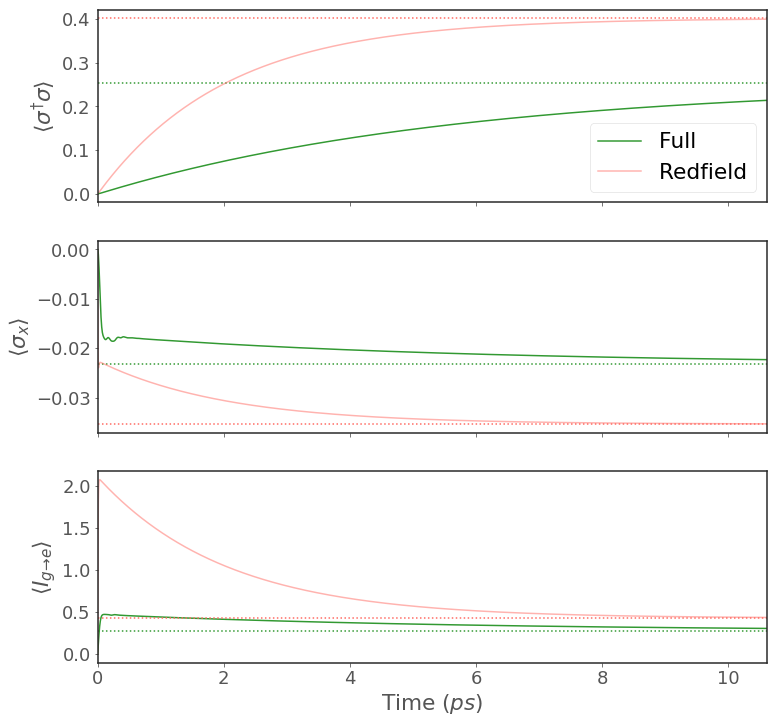

Detuning : 1.0000meV
Dynamics complete


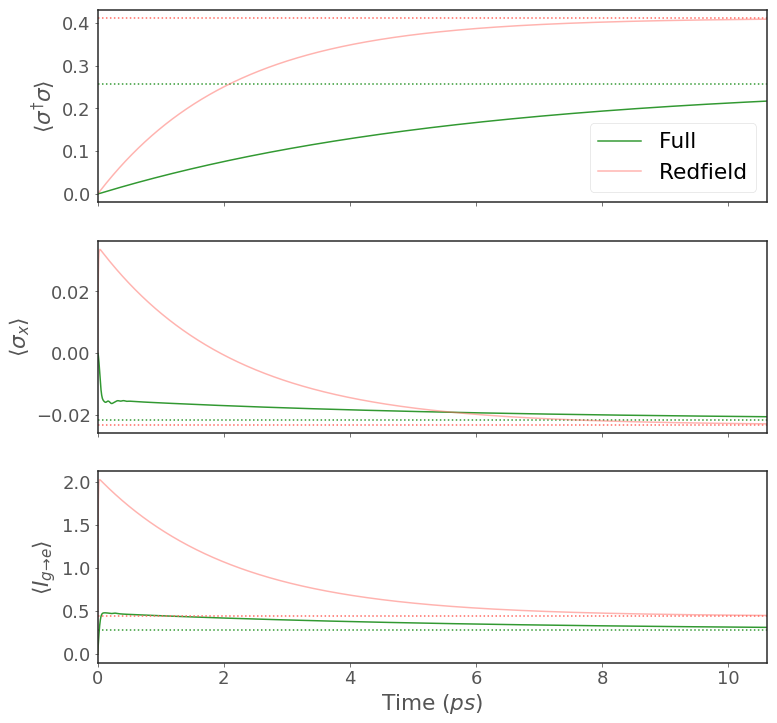

Detuning : 3.0000meV
Dynamics complete


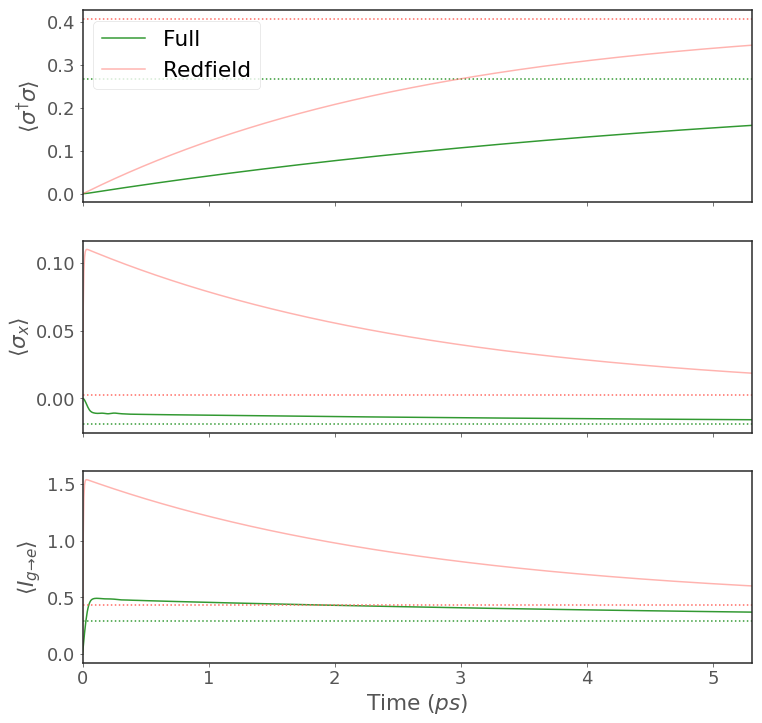

Detuning : 6.0000meV
Dynamics complete


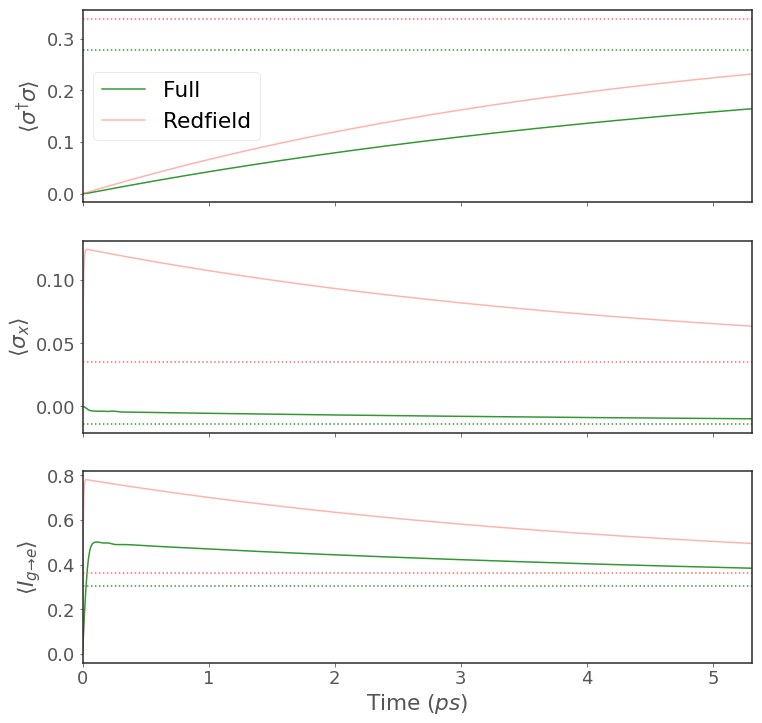

USING N=8
Detuning : 0.0010meV
Dynamics complete


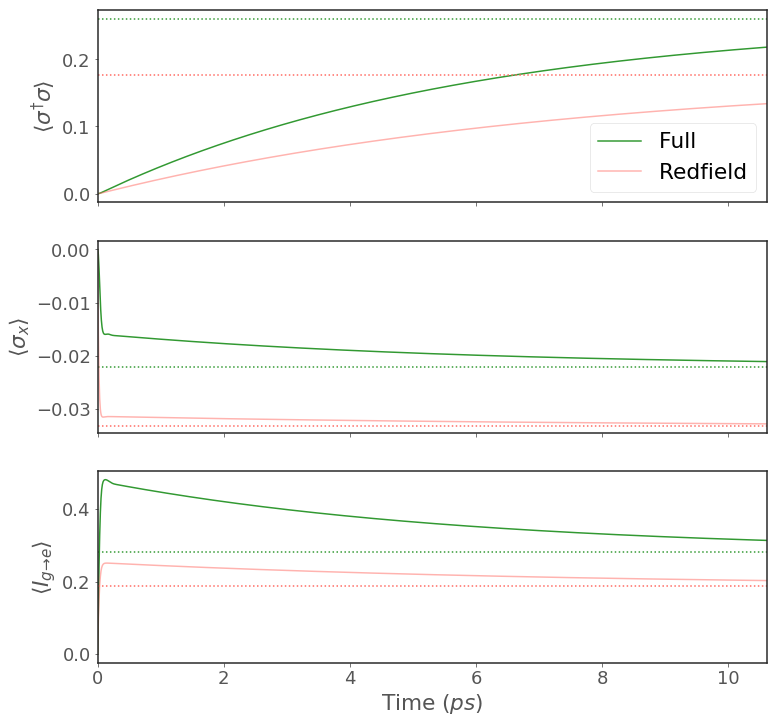

Detuning : 1.0000meV
Dynamics complete


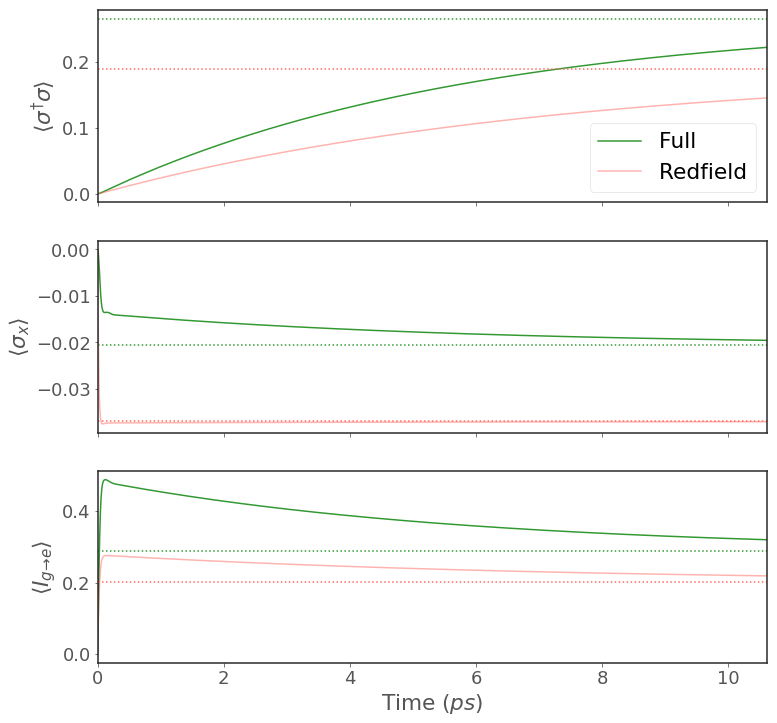

Detuning : 3.0000meV
Dynamics complete


Detuning : 6.0000meV
Dynamics complete


USING N=8
Detuning : 0.0010meV
Dynamics complete


Detuning : 1.0000meV
Dynamics complete


Detuning : 3.0000meV


ValueError: Integrals couldn't converge

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/admin/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/admin/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 421, in execute_request
    self._abort_queues()
  File "/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 636, in _abort_queues
    self._abort_queue(stream)
  File "/Users/admin/anaconda3/lib

In [ ]:
# highest T, intermediate coupling
T=150
alpha=10e-3
Gamma = 12e-3
Rabi = 1e-3
tf=2
for w0 in [6e-3, 12e-3, 18e-3]:
    get_data_and_plot_for_detunings(T=T, alpha=alpha, w0=w0, Gamma=Gamma, Rabi = Rabi, tf=tf, wc_tol=1e-6)

In [ ]:
# highest T, intermediate Rabi
T=150
alpha=1e-3
Gamma = 12e-3
Rabi = 10e-3
tf=2
for w0 in [6e-3, 12e-3, 18e-3]:
    get_data_and_plot_for_detunings(T=T, alpha=alpha, w0=w0, Gamma=Gamma, Rabi = Rabi, tf=tf, wc_tol=1e-6)

In [320]:
def bloch_plot(data, pars):
    
    sigx = data.expect[1]
    sigy = data.expect[2]/pars[0]
    sigz = data.expect[0]-data.expect[3]
    
    b = qt.Bloch(view=[30, 30])
    b.add_points([sigx, sigy, sigz])
    b.show()
    b.view
bloch_plot(data_full, pars)